In [1]:
#Imporing libraries
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from torch.autograd import Variable
%matplotlib inline
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression

np.random.seed(1234)
torch.manual_seed(1234)

In [2]:
#Reading data
learn_data = pd.read_csv("bigml_59c28831336c6604c800002a.csv")
pd.options.display.max_columns = None
learn_data

,state,account length,area code,phone number,international plan,voice mail plan,number vmail messages,total day minutes,total day calls,total day charge,total eve minutes,total eve calls,total eve charge,total night minutes,total night calls,total night charge,total intl minutes,total intl calls,total intl charge,customer service calls,churn
0,KS,128,415,382-4657,no,yes,25,265.1,110,45.07,197.4,99,16.78,244.7,91,11.01,10.0,3,2.70,1,False
1,OH,107,415,371-7191,no,yes,26,161.6,123,27.47,195.5,103,16.62,254.4,103,11.45,13.7,3,3.70,1,False
2,NJ,137,415,358-1921,no,no,0,243.4,114,41.38,121.2,110,10.30,162.6,104,7.32,12.2,5,3.29,0,False
3,OH,84,408,375-9999,yes,no,0,299.4,71,50.90,61.9,88,5.26,196.9,89,8.86,6.6,7,1.78,2,False
4,OK,75,415,330-6626,yes,no,0,166.7,113,28.34,148.3,122,12.61,186.9,121,8.41,10.1,3,2.73,3,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3328,AZ,192,415,414-4276,no,yes,36,156.2,77,26.55,215.5,126,18.32,279.1,83,12.56,9.9,6,2.67,2,False
3329,WV,68,415,370-3271,no,no,0,231.1,57,39.29,153.4,55,13.04,191.3,123,8.61,9.6,4,2.59,3,False
3330,RI,28,510,328-8230,no,no,0,180.8,109,30.74,288.8,58,24.55,191.9,91,8.64,14.1,6,3.81,2,False
3331,CT,184,510,364-6381,yes,no,0,213.8,105,36.35,159.6,84,13.57,139.2,137,6.26,5.0,10,1.35,2,False


In [3]:
#Defining columns
numerical_columns = ['number vmail messages', 'total day minutes', 'total day calls',
                     'total day charge', 'total eve minutes', 'total eve calls', 'total eve charge', 'total night minutes',
                     'total night calls', 'total night charge', 'total intl minutes', 'total intl calls',
                     'total intl charge', 'customer service calls']
categorical_columns = ['state', 'international plan', 'voice mail plan','area code']
outputs = ['churn']

In [4]:
churn_data = learn_data[learn_data['churn'] == 'True']
notchurn_data = learn_data[learn_data['churn'] == 'False']

C:\Users\BN000275553\AppData\Local\Continuum\anaconda3\envs\emb\lib\site-packages\pandas\core\ops\array_ops.py:253: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  res_values = method(rvalues)


In [5]:
#Processing columns

#Numerical
numerical_data = np.stack([learn_data[col].values for col in numerical_columns], 1)
numerical_data = torch.tensor(numerical_data, dtype=torch.float)

#Categorical
for category in categorical_columns:
    learn_data[category] = learn_data[category].astype('category')
    
st = learn_data['state'].cat.codes.values
ip = learn_data['international plan'].cat.codes.values
vm = learn_data['voice mail plan'].cat.codes.values
ac = learn_data['area code'].cat.codes.values

categorical_data = np.stack([st, ip, vm, ac], 1)
categorical_data = torch.tensor(categorical_data, dtype=torch.int64)

#Outputs
learn_data[outputs] = learn_data[outputs].astype(int)

outputs = torch.tensor(learn_data[outputs].values).flatten()
outputs = outputs.long()

In [6]:
#Dividing the data
total_records = 3333
train_records = int(total_records * .6)
valid_records = int(total_records * .2)
test_records = int(total_records * .2)
numerical_train_data = numerical_data[:train_records]
numerical_valid_data = numerical_data[train_records:train_records+valid_records]
numerical_test_data = numerical_data[train_records+valid_records:total_records]
categorical_train_data = categorical_data[:train_records]
categorical_valid_data = categorical_data[train_records:train_records+valid_records]
categorical_test_data = categorical_data[train_records+valid_records:total_records]
train_outputs = outputs[:train_records]
valid_outputs = outputs[train_records:train_records+valid_records]
test_outputs = outputs[train_records+valid_records:total_records]

In [7]:
from torch.nn.parameter import Parameter
from torch.nn import init
import math

#Creating the Neural Network
class Model(nn.Module):

    def __init__(self):
        super().__init__()
        self.layer1 = nn.Linear(14, 100)
        self.relu = nn.ReLU(inplace=True)
        self.bn1 = nn.BatchNorm1d(100)
        self.weights1 = Parameter(torch.Tensor(1, 120))
        init.kaiming_uniform_(self.weights1, a=math.sqrt(5))
        
        self.weights2 = Parameter(torch.Tensor(1, 120))
        init.kaiming_uniform_(self.weights2, a=math.sqrt(5))
        
        self.bias1 = Parameter(torch.Tensor(1))
        fan_in, _ = init._calculate_fan_in_and_fan_out(self.weights1)
        bound = 1 / math.sqrt(fan_in)
        init.uniform_(self.bias1, -bound, bound)
        
        self.bias2 = Parameter(torch.Tensor(1))
        fan_in, _ = init._calculate_fan_in_and_fan_out(self.weights2)
        bound = 1 / math.sqrt(fan_in)
        init.uniform_(self.bias2, -bound, bound)
        
        self.layer1_1 = nn.Embedding(51, 5)
        self.bn1_1 = nn.BatchNorm1d(5)
        self.layer1_2 = nn.Embedding(2, 5)
        self.bn1_2 = nn.BatchNorm1d(5)
        self.layer1_3 = nn.Embedding(2, 5)
        self.bn1_3 = nn.BatchNorm1d(5)
        self.layer1_4 = nn.Embedding(3, 5)
        self.bn1_4 = nn.BatchNorm1d(5)
        
        self.layer2 = nn.Linear(120, 120)
        self.bn2 = nn.BatchNorm1d(120)
        
    def forward(self, x_numerical, x_categorical):
        x1 = self.layer1(x_numerical)
        x1 = self.relu(x1)
        x1 = self.bn1(x1)
        
        x1_embedding = self.layer1_1(x_categorical[:,0])
        x1_embedding = self.relu(x1_embedding)
        x1_embedding = self.bn1_1(x1_embedding)
        
        x2_embedding = self.layer1_2(x_categorical[:,1])
        x2_embedding = self.relu(x2_embedding)
        x2_embedding = self.bn1_2(x2_embedding)
        
        x3_embedding = self.layer1_3(x_categorical[:,2])
        x3_embedding = self.relu(x3_embedding)
        x3_embedding = self.bn1_3(x3_embedding)
        
        x4_embedding = self.layer1_4(x_categorical[:,3])
        x4_embedding = self.relu(x4_embedding)
        x4_embedding = self.bn1_4(x4_embedding)
        
        x_embedding = torch.cat([x1_embedding,x2_embedding,x3_embedding,x4_embedding], 1)
                
        x1 = torch.cat([x1, x_embedding], 1)
        
        x2 = self.layer2(x1)        
        emb = self.relu(x2)
        x2 = self.bn2(emb)
        
        
        x2_weights1 = torch.mm(x2, self.weights1.t()) + self.bias1
        x2_weights2 = torch.mm(x2, self.weights2.t()) + self.bias2
        
        x3 = torch.cat([x2_weights1, x2_weights2], 1)
        
                
        return emb, self.weights1, self.weights2, x3

In [8]:
model = Model()

In [9]:
#===============================================================================================
# Defining churn:loyal weight ratio. churn_percentage=0.7 means churn:loyal weight ratio of 7:3.
# Setting churn_percentage=0.5 to get an unweighted model
#===============================================================================================
churn_percentage = 0.7

#Defining loss function
loss_function = nn.CrossEntropyLoss(weight=torch.Tensor([1-churn_percentage, churn_percentage]))
# loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
#29 Juni 2020: menambahkan scheduler learning rate
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, 0.9)

In [10]:
#Training the data
epochs = 100 
batch_size = 10
mean_losses_train = []
mean_losses_valid = []
best_loss_valid = np.inf

for i in range(epochs):
    model.train()
    aggregated_losses_train = []
    aggregated_losses_valid = []
    i += 1
    idxs = np.random.permutation(train_records)
    for j in range((train_records//batch_size)+1):
        start_train = j*batch_size
        end_train = start_train+batch_size
        
        idxs_batch = idxs[start_train:end_train]
        
        train, weights1, weights2, train_embed = model(numerical_train_data[idxs_batch], categorical_train_data[idxs_batch]) # yg error 1
        train_loss = loss_function(train_embed, train_outputs[idxs_batch])
        aggregated_losses_train.append(train_loss)

        print(f'iteration: {j:3} loss: {train_loss.item():10.8f}')

        optimizer.zero_grad()
        train_loss.backward()
        optimizer.step()
        mean_loss_train = torch.mean(torch.stack(aggregated_losses_train))
        
    print(f'epoch: {i:3} mean loss training: {mean_loss_train.item():10.8f}')
    mean_losses_train.append(mean_loss_train)
    
    model.eval()
    with torch.set_grad_enabled(False):
        for k in range((valid_records//batch_size)+1):
            start_valid = k*batch_size
            end_valid = start_valid+batch_size
            valid, weights1, weights2, valid_embed = model(numerical_valid_data[start_valid:end_valid], categorical_valid_data[start_valid:end_valid]) # kenapa disini harus ada 2 variabel prefix
            valid_loss = loss_function(valid_embed, valid_outputs[start_valid:end_valid])
            aggregated_losses_valid.append(valid_loss)
    mean_loss_valid = torch.mean(torch.stack(aggregated_losses_valid))
    print(f'epoch: {i:3} mean loss validation: {mean_loss_valid:.8f}')
    
    if mean_loss_valid.cpu().numpy()[()] < best_loss_valid:
        best_loss_valid = mean_loss_valid
        torch.save(model.state_dict(), "model_train_cre_{}.pth".format(churn_percentage))
        best_epoch = i        
    
    mean_losses_valid.append(mean_loss_valid)
    scheduler.step()

iteration:   0 loss: 0.82103920
iteration:   1 loss: 0.79437244
iteration:   2 loss: 0.79688013
iteration:   3 loss: 0.73464829
iteration:   4 loss: 0.68968529
iteration:   5 loss: 0.72511816
iteration:   6 loss: 0.74404383
iteration:   7 loss: 0.65215856
iteration:   8 loss: 0.71484601
iteration:   9 loss: 0.69938260
iteration:  10 loss: 1.02452350
iteration:  11 loss: 0.81168485
iteration:  12 loss: 0.58278143
iteration:  13 loss: 0.64885712
iteration:  14 loss: 0.67953175
iteration:  15 loss: 0.70961940
iteration:  16 loss: 0.84983289
iteration:  17 loss: 0.48716709
iteration:  18 loss: 0.52003825
iteration:  19 loss: 0.75300992
iteration:  20 loss: 0.43862265
iteration:  21 loss: 0.57895112
iteration:  22 loss: 0.59149247
iteration:  23 loss: 0.73644382
iteration:  24 loss: 0.81363302
iteration:  25 loss: 0.63281393
iteration:  26 loss: 0.60495085
iteration:  27 loss: 0.45101538
iteration:  28 loss: 0.59238750
iteration:  29 loss: 0.43997455
iteration:  30 loss: 0.59559214
iteratio

iteration:  57 loss: 0.50769788
iteration:  58 loss: 0.33411658
iteration:  59 loss: 1.02553904
iteration:  60 loss: 0.36600101
iteration:  61 loss: 0.62106591
iteration:  62 loss: 0.17905657
iteration:  63 loss: 0.86319822
iteration:  64 loss: 0.27958417
iteration:  65 loss: 0.33377004
iteration:  66 loss: 0.23373316
iteration:  67 loss: 1.09118032
iteration:  68 loss: 0.59860563
iteration:  69 loss: 0.97234529
iteration:  70 loss: 0.64076716
iteration:  71 loss: 0.40812594
iteration:  72 loss: 0.60408312
iteration:  73 loss: 0.25344899
iteration:  74 loss: 0.33279222
iteration:  75 loss: 0.77119893
iteration:  76 loss: 0.74717993
iteration:  77 loss: 0.27859151
iteration:  78 loss: 0.66582531
iteration:  79 loss: 0.34258336
iteration:  80 loss: 0.38629711
iteration:  81 loss: 0.29647690
iteration:  82 loss: 0.34329802
iteration:  83 loss: 0.35850647
iteration:  84 loss: 0.32160971
iteration:  85 loss: 0.79476410
iteration:  86 loss: 0.34695441
iteration:  87 loss: 0.51028758
iteratio

iteration: 114 loss: 0.43543431
iteration: 115 loss: 0.22347076
iteration: 116 loss: 0.25583634
iteration: 117 loss: 0.24616784
iteration: 118 loss: 0.34140760
iteration: 119 loss: 0.96179312
iteration: 120 loss: 0.18203945
iteration: 121 loss: 0.21931170
iteration: 122 loss: 0.30241483
iteration: 123 loss: 0.31418300
iteration: 124 loss: 1.03927422
iteration: 125 loss: 0.38168764
iteration: 126 loss: 0.18754826
iteration: 127 loss: 0.32744813
iteration: 128 loss: 0.15744837
iteration: 129 loss: 0.46639940
iteration: 130 loss: 0.30644077
iteration: 131 loss: 0.68866748
iteration: 132 loss: 0.21443458
iteration: 133 loss: 0.14040270
iteration: 134 loss: 0.92404771
iteration: 135 loss: 0.92282349
iteration: 136 loss: 0.26399159
iteration: 137 loss: 0.24594539
iteration: 138 loss: 0.76039183
iteration: 139 loss: 0.17059597
iteration: 140 loss: 0.47744185
iteration: 141 loss: 0.36052358
iteration: 142 loss: 0.65250564
iteration: 143 loss: 0.21950559
iteration: 144 loss: 1.04716074
iteratio

iteration: 169 loss: 0.85887861
iteration: 170 loss: 0.44981289
iteration: 171 loss: 0.47488636
iteration: 172 loss: 0.13470648
iteration: 173 loss: 0.58021522
iteration: 174 loss: 0.68095261
iteration: 175 loss: 0.30965129
iteration: 176 loss: 0.28971815
iteration: 177 loss: 0.62027991
iteration: 178 loss: 0.29539597
iteration: 179 loss: 0.28628486
iteration: 180 loss: 0.25618616
iteration: 181 loss: 0.72811067
iteration: 182 loss: 0.27080107
iteration: 183 loss: 0.69996315
iteration: 184 loss: 0.31095472
iteration: 185 loss: 0.23354171
iteration: 186 loss: 0.27530244
iteration: 187 loss: 0.27325258
iteration: 188 loss: 0.43172425
iteration: 189 loss: 0.21580386
iteration: 190 loss: 0.41768014
iteration: 191 loss: 0.27425480
iteration: 192 loss: 0.24122697
iteration: 193 loss: 0.27833524
iteration: 194 loss: 0.12724613
iteration: 195 loss: 0.54042751
iteration: 196 loss: 1.17623794
iteration: 197 loss: 0.55688554
iteration: 198 loss: 0.28084657
iteration: 199 loss: 0.64587843
epoch:  

iteration:  22 loss: 0.39818162
iteration:  23 loss: 0.31289423
iteration:  24 loss: 0.20668182
iteration:  25 loss: 0.54360628
iteration:  26 loss: 0.26294968
iteration:  27 loss: 0.30124512
iteration:  28 loss: 0.90113127
iteration:  29 loss: 0.65019846
iteration:  30 loss: 0.33799973
iteration:  31 loss: 0.33256307
iteration:  32 loss: 0.10737838
iteration:  33 loss: 0.22791070
iteration:  34 loss: 0.76436526
iteration:  35 loss: 0.14013328
iteration:  36 loss: 0.69295883
iteration:  37 loss: 0.17651197
iteration:  38 loss: 0.19767405
iteration:  39 loss: 0.23908855
iteration:  40 loss: 0.40738690
iteration:  41 loss: 0.64330083
iteration:  42 loss: 0.26933897
iteration:  43 loss: 1.01681507
iteration:  44 loss: 0.14222026
iteration:  45 loss: 0.25979730
iteration:  46 loss: 0.24529271
iteration:  47 loss: 0.13346286
iteration:  48 loss: 1.27500260
iteration:  49 loss: 0.51471537
iteration:  50 loss: 0.62982059
iteration:  51 loss: 0.30490029
iteration:  52 loss: 0.51217932
iteratio

iteration:  79 loss: 0.22982432
iteration:  80 loss: 0.36133966
iteration:  81 loss: 0.47152793
iteration:  82 loss: 0.32229853
iteration:  83 loss: 0.59740847
iteration:  84 loss: 0.28471676
iteration:  85 loss: 0.23873259
iteration:  86 loss: 0.37239662
iteration:  87 loss: 0.15480180
iteration:  88 loss: 0.29507703
iteration:  89 loss: 0.25548321
iteration:  90 loss: 0.25519887
iteration:  91 loss: 0.16288842
iteration:  92 loss: 0.37938085
iteration:  93 loss: 0.25153276
iteration:  94 loss: 0.21026476
iteration:  95 loss: 0.32359532
iteration:  96 loss: 0.39519805
iteration:  97 loss: 0.29720297
iteration:  98 loss: 0.54401207
iteration:  99 loss: 0.12316447
iteration: 100 loss: 0.46927798
iteration: 101 loss: 0.79912359
iteration: 102 loss: 0.73564011
iteration: 103 loss: 0.43580282
iteration: 104 loss: 0.96313572
iteration: 105 loss: 0.62922543
iteration: 106 loss: 0.21891795
iteration: 107 loss: 0.22736035
iteration: 108 loss: 0.20563318
iteration: 109 loss: 0.42711106
iteratio

iteration: 134 loss: 0.81957644
iteration: 135 loss: 0.49305311
iteration: 136 loss: 0.34449735
iteration: 137 loss: 0.19232972
iteration: 138 loss: 0.65738332
iteration: 139 loss: 0.63594198
iteration: 140 loss: 0.68740404
iteration: 141 loss: 0.17390993
iteration: 142 loss: 0.46982214
iteration: 143 loss: 0.34077674
iteration: 144 loss: 0.11332793
iteration: 145 loss: 0.22072917
iteration: 146 loss: 0.54647917
iteration: 147 loss: 0.45904174
iteration: 148 loss: 0.09866233
iteration: 149 loss: 0.59315449
iteration: 150 loss: 0.44870442
iteration: 151 loss: 0.19703099
iteration: 152 loss: 0.14504029
iteration: 153 loss: 0.12206906
iteration: 154 loss: 0.35322189
iteration: 155 loss: 0.42492577
iteration: 156 loss: 0.25226232
iteration: 157 loss: 0.19998062
iteration: 158 loss: 0.78987545
iteration: 159 loss: 0.19267425
iteration: 160 loss: 0.27201241
iteration: 161 loss: 0.34334794
iteration: 162 loss: 0.40091047
iteration: 163 loss: 0.59162021
iteration: 164 loss: 0.43274379
iteratio

iteration: 189 loss: 0.24552836
iteration: 190 loss: 0.23473060
iteration: 191 loss: 0.40072203
iteration: 192 loss: 0.32636058
iteration: 193 loss: 0.42733818
iteration: 194 loss: 0.44550189
iteration: 195 loss: 0.19138250
iteration: 196 loss: 0.41084030
iteration: 197 loss: 0.89571226
iteration: 198 loss: 0.61656713
iteration: 199 loss: 1.03419983
epoch:   9 mean loss training: 0.37581012
epoch:   9 mean loss validation: 0.37192357
iteration:   0 loss: 0.48951885
iteration:   1 loss: 0.32000396
iteration:   2 loss: 0.23825802
iteration:   3 loss: 0.15006845
iteration:   4 loss: 0.56580567
iteration:   5 loss: 0.23699021
iteration:   6 loss: 0.30158916
iteration:   7 loss: 0.27228853
iteration:   8 loss: 0.24869068
iteration:   9 loss: 0.24089354
iteration:  10 loss: 0.35283524
iteration:  11 loss: 0.51348448
iteration:  12 loss: 0.30138767
iteration:  13 loss: 0.68318236
iteration:  14 loss: 0.20436125
iteration:  15 loss: 0.44048044
iteration:  16 loss: 0.40936342
iteration:  17 los

iteration:  41 loss: 0.62169826
iteration:  42 loss: 0.90120506
iteration:  43 loss: 0.27734226
iteration:  44 loss: 0.13114873
iteration:  45 loss: 0.45004597
iteration:  46 loss: 0.49653369
iteration:  47 loss: 0.32597128
iteration:  48 loss: 0.65994084
iteration:  49 loss: 0.17220321
iteration:  50 loss: 0.12379851
iteration:  51 loss: 0.69767016
iteration:  52 loss: 0.41733041
iteration:  53 loss: 0.20041783
iteration:  54 loss: 0.49194354
iteration:  55 loss: 0.21816947
iteration:  56 loss: 0.82236868
iteration:  57 loss: 0.58088589
iteration:  58 loss: 0.26718652
iteration:  59 loss: 0.36386535
iteration:  60 loss: 0.30643740
iteration:  61 loss: 0.47194931
iteration:  62 loss: 0.22554569
iteration:  63 loss: 0.18863881
iteration:  64 loss: 0.22796816
iteration:  65 loss: 0.19028242
iteration:  66 loss: 0.60902721
iteration:  67 loss: 0.37088019
iteration:  68 loss: 0.23525345
iteration:  69 loss: 0.83041191
iteration:  70 loss: 0.23115458
iteration:  71 loss: 0.47405389
iteratio

iteration:  99 loss: 0.11307515
iteration: 100 loss: 0.10879113
iteration: 101 loss: 0.53521216
iteration: 102 loss: 0.14265250
iteration: 103 loss: 0.55815428
iteration: 104 loss: 0.23437203
iteration: 105 loss: 0.24060200
iteration: 106 loss: 0.32413125
iteration: 107 loss: 1.17820191
iteration: 108 loss: 0.85692179
iteration: 109 loss: 0.22872810
iteration: 110 loss: 0.16762246
iteration: 111 loss: 0.62754923
iteration: 112 loss: 0.52354473
iteration: 113 loss: 0.57442355
iteration: 114 loss: 0.21814276
iteration: 115 loss: 0.32523817
iteration: 116 loss: 0.47111598
iteration: 117 loss: 0.13725768
iteration: 118 loss: 0.37185413
iteration: 119 loss: 0.33263555
iteration: 120 loss: 0.21821101
iteration: 121 loss: 0.25756609
iteration: 122 loss: 0.99664974
iteration: 123 loss: 0.46186423
iteration: 124 loss: 0.56697434
iteration: 125 loss: 0.69879842
iteration: 126 loss: 0.80113155
iteration: 127 loss: 0.17460203
iteration: 128 loss: 0.24482678
iteration: 129 loss: 0.20593937
iteratio

iteration: 153 loss: 0.64114141
iteration: 154 loss: 0.31318736
iteration: 155 loss: 0.22775905
iteration: 156 loss: 0.42907342
iteration: 157 loss: 0.34967038
iteration: 158 loss: 1.12096095
iteration: 159 loss: 0.18014725
iteration: 160 loss: 0.18337443
iteration: 161 loss: 0.16953075
iteration: 162 loss: 0.16888286
iteration: 163 loss: 0.23280309
iteration: 164 loss: 0.47270948
iteration: 165 loss: 0.20999981
iteration: 166 loss: 0.51860154
iteration: 167 loss: 0.58364248
iteration: 168 loss: 0.19294296
iteration: 169 loss: 0.87758547
iteration: 170 loss: 0.24512409
iteration: 171 loss: 0.12826553
iteration: 172 loss: 0.13630232
iteration: 173 loss: 0.18286166
iteration: 174 loss: 0.21827759
iteration: 175 loss: 0.41261744
iteration: 176 loss: 0.21392824
iteration: 177 loss: 0.17598079
iteration: 178 loss: 0.48979342
iteration: 179 loss: 0.13135777
iteration: 180 loss: 0.53671515
iteration: 181 loss: 0.32941139
iteration: 182 loss: 0.47200722
iteration: 183 loss: 0.15682283
iteratio

iteration:   8 loss: 0.76264495
iteration:   9 loss: 0.19642749
iteration:  10 loss: 0.17077298
iteration:  11 loss: 0.30184886
iteration:  12 loss: 0.24568579
iteration:  13 loss: 0.24602498
iteration:  14 loss: 0.38567236
iteration:  15 loss: 0.40223962
iteration:  16 loss: 0.10817089
iteration:  17 loss: 0.33374611
iteration:  18 loss: 0.72332931
iteration:  19 loss: 0.69834888
iteration:  20 loss: 0.22540931
iteration:  21 loss: 0.21889281
iteration:  22 loss: 0.33266604
iteration:  23 loss: 0.19653763
iteration:  24 loss: 0.18357325
iteration:  25 loss: 0.81364489
iteration:  26 loss: 0.45514667
iteration:  27 loss: 1.15811443
iteration:  28 loss: 0.11005640
iteration:  29 loss: 0.41310704
iteration:  30 loss: 0.30579269
iteration:  31 loss: 0.31022322
iteration:  32 loss: 0.25882092
iteration:  33 loss: 0.41852829
iteration:  34 loss: 0.60297585
iteration:  35 loss: 0.28745535
iteration:  36 loss: 0.30284998
iteration:  37 loss: 0.68057865
iteration:  38 loss: 0.36436304
iteratio

iteration:  68 loss: 0.31025767
iteration:  69 loss: 0.23644015
iteration:  70 loss: 0.13724214
iteration:  71 loss: 0.25308022
iteration:  72 loss: 0.30448446
iteration:  73 loss: 0.64221776
iteration:  74 loss: 0.31634176
iteration:  75 loss: 0.16782776
iteration:  76 loss: 0.26920533
iteration:  77 loss: 0.17176545
iteration:  78 loss: 0.27966517
iteration:  79 loss: 0.25061765
iteration:  80 loss: 0.26967379
iteration:  81 loss: 0.44122025
iteration:  82 loss: 0.24389626
iteration:  83 loss: 0.19901444
iteration:  84 loss: 0.22193490
iteration:  85 loss: 0.17222433
iteration:  86 loss: 0.46231443
iteration:  87 loss: 0.27375141
iteration:  88 loss: 0.58390623
iteration:  89 loss: 0.26204526
iteration:  90 loss: 0.29077402
iteration:  91 loss: 0.41954967
iteration:  92 loss: 0.35881105
iteration:  93 loss: 0.14144278
iteration:  94 loss: 0.27339697
iteration:  95 loss: 0.26922885
iteration:  96 loss: 0.89133137
iteration:  97 loss: 0.28322020
iteration:  98 loss: 0.26854259
iteratio

iteration: 128 loss: 0.31472278
iteration: 129 loss: 0.40454289
iteration: 130 loss: 0.41173068
iteration: 131 loss: 0.18233387
iteration: 132 loss: 0.35656172
iteration: 133 loss: 0.61693937
iteration: 134 loss: 0.11026893
iteration: 135 loss: 0.12711442
iteration: 136 loss: 0.95244455
iteration: 137 loss: 0.27135697
iteration: 138 loss: 0.27873626
iteration: 139 loss: 0.29332545
iteration: 140 loss: 0.29261565
iteration: 141 loss: 0.28041711
iteration: 142 loss: 0.64906567
iteration: 143 loss: 0.56399995
iteration: 144 loss: 0.17592806
iteration: 145 loss: 0.09448741
iteration: 146 loss: 0.25532916
iteration: 147 loss: 0.11411525
iteration: 148 loss: 0.19229658
iteration: 149 loss: 0.19109017
iteration: 150 loss: 0.15089342
iteration: 151 loss: 0.21911342
iteration: 152 loss: 0.14735596
iteration: 153 loss: 0.22619753
iteration: 154 loss: 0.23184164
iteration: 155 loss: 0.44370171
iteration: 156 loss: 0.36517075
iteration: 157 loss: 0.17844857
iteration: 158 loss: 0.14094520
iteratio

iteration: 182 loss: 0.11073126
iteration: 183 loss: 0.17567946
iteration: 184 loss: 0.16384628
iteration: 185 loss: 0.27602494
iteration: 186 loss: 0.15497166
iteration: 187 loss: 0.16102563
iteration: 188 loss: 0.27411431
iteration: 189 loss: 0.33233622
iteration: 190 loss: 0.21533963
iteration: 191 loss: 0.57310200
iteration: 192 loss: 0.46059898
iteration: 193 loss: 0.30012268
iteration: 194 loss: 0.25450742
iteration: 195 loss: 0.30657828
iteration: 196 loss: 0.22698914
iteration: 197 loss: 0.18367073
iteration: 198 loss: 0.24710763
iteration: 199 loss: 0.41646481
epoch:  18 mean loss training: 0.34493420
epoch:  18 mean loss validation: 0.33765048
iteration:   0 loss: 0.22655807
iteration:   1 loss: 0.17246526
iteration:   2 loss: 0.45210338
iteration:   3 loss: 0.27429256
iteration:   4 loss: 0.30803308
iteration:   5 loss: 0.24707399
iteration:   6 loss: 0.16199990
iteration:   7 loss: 0.24030849
iteration:   8 loss: 0.21961309
iteration:   9 loss: 0.23526666
iteration:  10 los

iteration:  33 loss: 0.45077312
iteration:  34 loss: 0.47969723
iteration:  35 loss: 0.22042052
iteration:  36 loss: 0.42844048
iteration:  37 loss: 0.18768547
iteration:  38 loss: 0.17155214
iteration:  39 loss: 0.08046988
iteration:  40 loss: 0.16456905
iteration:  41 loss: 0.22000653
iteration:  42 loss: 0.35650963
iteration:  43 loss: 0.15948056
iteration:  44 loss: 0.18939865
iteration:  45 loss: 0.28253493
iteration:  46 loss: 0.23570585
iteration:  47 loss: 0.88836432
iteration:  48 loss: 0.48123038
iteration:  49 loss: 0.32012764
iteration:  50 loss: 0.29125082
iteration:  51 loss: 0.16790758
iteration:  52 loss: 0.39912814
iteration:  53 loss: 0.26989478
iteration:  54 loss: 0.29261005
iteration:  55 loss: 0.18900321
iteration:  56 loss: 0.25916329
iteration:  57 loss: 0.78683567
iteration:  58 loss: 0.33332783
iteration:  59 loss: 0.29105803
iteration:  60 loss: 0.36309448
iteration:  61 loss: 0.37120071
iteration:  62 loss: 0.17042898
iteration:  63 loss: 0.20805521
iteratio

iteration: 144 loss: 0.48207033
iteration: 145 loss: 0.27953440
iteration: 146 loss: 0.15319899
iteration: 147 loss: 0.13691698
iteration: 148 loss: 0.13310073
iteration: 149 loss: 0.15540083
iteration: 150 loss: 0.08939047
iteration: 151 loss: 0.74334288
iteration: 152 loss: 0.08257394
iteration: 153 loss: 0.15248829
iteration: 154 loss: 0.19091146
iteration: 155 loss: 0.18672925
iteration: 156 loss: 0.17265388
iteration: 157 loss: 0.10664921
iteration: 158 loss: 0.49512830
iteration: 159 loss: 0.15017913
iteration: 160 loss: 0.19138850
iteration: 161 loss: 0.16782667
iteration: 162 loss: 0.20080487
iteration: 163 loss: 0.58255142
iteration: 164 loss: 0.20959969
iteration: 165 loss: 0.14635061
iteration: 166 loss: 0.17974995
iteration: 167 loss: 0.14367507
iteration: 168 loss: 0.20762202
iteration: 169 loss: 0.17297268
iteration: 170 loss: 0.09683431
iteration: 171 loss: 0.19020854
iteration: 172 loss: 0.25808579
iteration: 173 loss: 1.15083265
iteration: 174 loss: 0.22812678
iteratio

iteration:  50 loss: 0.14217134
iteration:  51 loss: 0.14309390
iteration:  52 loss: 0.35972580
iteration:  53 loss: 0.40482479
iteration:  54 loss: 0.53872591
iteration:  55 loss: 0.16994613
iteration:  56 loss: 0.84101444
iteration:  57 loss: 0.27244437
iteration:  58 loss: 0.12369104
iteration:  59 loss: 0.23550864
iteration:  60 loss: 0.26672152
iteration:  61 loss: 0.80349851
iteration:  62 loss: 0.17043047
iteration:  63 loss: 0.37251535
iteration:  64 loss: 0.18534057
iteration:  65 loss: 0.54044390
iteration:  66 loss: 0.22283170
iteration:  67 loss: 0.16601828
iteration:  68 loss: 0.40250257
iteration:  69 loss: 0.70950377
iteration:  70 loss: 0.84272641
iteration:  71 loss: 0.17676359
iteration:  72 loss: 0.17856760
iteration:  73 loss: 0.08725651
iteration:  74 loss: 0.10762452
iteration:  75 loss: 0.20579705
iteration:  76 loss: 0.21660219
iteration:  77 loss: 0.20800175
iteration:  78 loss: 0.15333159
iteration:  79 loss: 0.34920970
iteration:  80 loss: 0.33731222
iteratio

iteration: 107 loss: 0.25505784
iteration: 108 loss: 0.31642279
iteration: 109 loss: 0.19439735
iteration: 110 loss: 0.25984502
iteration: 111 loss: 0.15750411
iteration: 112 loss: 0.19733724
iteration: 113 loss: 0.42964882
iteration: 114 loss: 0.23752464
iteration: 115 loss: 0.17919746
iteration: 116 loss: 0.17816778
iteration: 117 loss: 0.34864724
iteration: 118 loss: 0.51712096
iteration: 119 loss: 0.16746479
iteration: 120 loss: 0.27236074
iteration: 121 loss: 0.25457880
iteration: 122 loss: 0.12688327
iteration: 123 loss: 0.12007935
iteration: 124 loss: 0.27575907
iteration: 125 loss: 0.11426987
iteration: 126 loss: 0.17296714
iteration: 127 loss: 0.60971594
iteration: 128 loss: 0.60300523
iteration: 129 loss: 0.22841950
iteration: 130 loss: 0.39810854
iteration: 131 loss: 0.18232982
iteration: 132 loss: 0.15139818
iteration: 133 loss: 0.35253915
iteration: 134 loss: 0.17593110
iteration: 135 loss: 0.91005194
iteration: 136 loss: 0.06708436
iteration: 137 loss: 0.41532359
iteratio

iteration: 164 loss: 0.23764394
iteration: 165 loss: 0.17580548
iteration: 166 loss: 0.10906586
iteration: 167 loss: 0.15203208
iteration: 168 loss: 0.20361969
iteration: 169 loss: 0.23406579
iteration: 170 loss: 0.33990878
iteration: 171 loss: 0.43780696
iteration: 172 loss: 0.17719850
iteration: 173 loss: 0.28758749
iteration: 174 loss: 0.16335875
iteration: 175 loss: 0.54318118
iteration: 176 loss: 0.11572458
iteration: 177 loss: 0.70224476
iteration: 178 loss: 0.16494741
iteration: 179 loss: 0.19178736
iteration: 180 loss: 0.12275042
iteration: 181 loss: 0.49725401
iteration: 182 loss: 0.33237046
iteration: 183 loss: 0.05642233
iteration: 184 loss: 0.62860912
iteration: 185 loss: 0.24959981
iteration: 186 loss: 0.29944426
iteration: 187 loss: 0.18912363
iteration: 188 loss: 0.96391821
iteration: 189 loss: 0.12407564
iteration: 190 loss: 0.16786946
iteration: 191 loss: 0.21830359
iteration: 192 loss: 0.12631404
iteration: 193 loss: 0.21525684
iteration: 194 loss: 0.11804350
iteratio

iteration:  16 loss: 0.20453370
iteration:  17 loss: 0.16689965
iteration:  18 loss: 0.07404800
iteration:  19 loss: 0.13327336
iteration:  20 loss: 0.09145997
iteration:  21 loss: 0.11191067
iteration:  22 loss: 0.35384429
iteration:  23 loss: 0.26898393
iteration:  24 loss: 0.34372410
iteration:  25 loss: 0.17613044
iteration:  26 loss: 0.08998804
iteration:  27 loss: 0.14567304
iteration:  28 loss: 0.16449134
iteration:  29 loss: 0.26746479
iteration:  30 loss: 0.57172745
iteration:  31 loss: 0.50854027
iteration:  32 loss: 0.45271847
iteration:  33 loss: 0.53476399
iteration:  34 loss: 0.13692978
iteration:  35 loss: 0.39180702
iteration:  36 loss: 0.32644522
iteration:  37 loss: 0.32540369
iteration:  38 loss: 0.24689506
iteration:  39 loss: 0.21722156
iteration:  40 loss: 0.48663533
iteration:  41 loss: 0.18095310
iteration:  42 loss: 0.27807736
iteration:  43 loss: 0.30883867
iteration:  44 loss: 0.26518729
iteration:  45 loss: 0.15210919
iteration:  46 loss: 0.35421407
iteratio

iteration:  75 loss: 0.10273170
iteration:  76 loss: 0.15006216
iteration:  77 loss: 0.13828290
iteration:  78 loss: 0.46893293
iteration:  79 loss: 0.10345291
iteration:  80 loss: 0.16391091
iteration:  81 loss: 0.64537138
iteration:  82 loss: 0.41353765
iteration:  83 loss: 0.27805784
iteration:  84 loss: 0.79336631
iteration:  85 loss: 0.43100393
iteration:  86 loss: 0.28007862
iteration:  87 loss: 0.17047116
iteration:  88 loss: 0.16793031
iteration:  89 loss: 0.82734215
iteration:  90 loss: 0.11992471
iteration:  91 loss: 0.17150712
iteration:  92 loss: 0.39399678
iteration:  93 loss: 0.10961173
iteration:  94 loss: 0.29793236
iteration:  95 loss: 0.26346141
iteration:  96 loss: 0.11507370
iteration:  97 loss: 0.42665336
iteration:  98 loss: 0.27928957
iteration:  99 loss: 0.11420986
iteration: 100 loss: 0.24850355
iteration: 101 loss: 0.25681984
iteration: 102 loss: 0.54217535
iteration: 103 loss: 0.25208759
iteration: 104 loss: 0.33615813
iteration: 105 loss: 0.16455227
iteratio

iteration: 134 loss: 0.25817904
iteration: 135 loss: 0.27008900
iteration: 136 loss: 0.09809250
iteration: 137 loss: 0.42955008
iteration: 138 loss: 0.17251402
iteration: 139 loss: 0.18183656
iteration: 140 loss: 0.46175519
iteration: 141 loss: 0.27891693
iteration: 142 loss: 0.11950986
iteration: 143 loss: 0.16801620
iteration: 144 loss: 0.92605680
iteration: 145 loss: 0.15287201
iteration: 146 loss: 0.56549859
iteration: 147 loss: 0.19802198
iteration: 148 loss: 0.10989165
iteration: 149 loss: 0.43348083
iteration: 150 loss: 0.15233168
iteration: 151 loss: 0.42943490
iteration: 152 loss: 0.27097234
iteration: 153 loss: 0.66465700
iteration: 154 loss: 0.67899114
iteration: 155 loss: 0.13785498
iteration: 156 loss: 0.08636447
iteration: 157 loss: 0.80978394
iteration: 158 loss: 0.22340417
iteration: 159 loss: 0.43924654
iteration: 160 loss: 0.44233716
iteration: 161 loss: 0.16120428
iteration: 162 loss: 0.11191326
iteration: 163 loss: 0.20268759
iteration: 164 loss: 0.34508038
iteratio

iteration: 194 loss: 0.15234497
iteration: 195 loss: 0.26685926
iteration: 196 loss: 0.12731835
iteration: 197 loss: 0.29885715
iteration: 198 loss: 0.67883831
iteration: 199 loss: 0.18283741
epoch:  32 mean loss training: 0.28989705
epoch:  32 mean loss validation: 0.34590742
iteration:   0 loss: 0.10583021
iteration:   1 loss: 0.31325573
iteration:   2 loss: 0.33062804
iteration:   3 loss: 0.32550561
iteration:   4 loss: 0.15487911
iteration:   5 loss: 0.08680893
iteration:   6 loss: 0.49845266
iteration:   7 loss: 0.72890097
iteration:   8 loss: 0.20437801
iteration:   9 loss: 0.14609332
iteration:  10 loss: 0.25492117
iteration:  11 loss: 0.15558434
iteration:  12 loss: 0.39615431
iteration:  13 loss: 0.60796314
iteration:  14 loss: 0.36694685
iteration:  15 loss: 0.81174272
iteration:  16 loss: 0.15217344
iteration:  17 loss: 0.66915256
iteration:  18 loss: 0.10142162
iteration:  19 loss: 0.69887120
iteration:  20 loss: 0.28052771
iteration:  21 loss: 0.45118344
iteration:  22 los

iteration:  51 loss: 0.60352951
iteration:  52 loss: 0.32807350
iteration:  53 loss: 1.10160053
iteration:  54 loss: 0.15702190
iteration:  55 loss: 0.14039642
iteration:  56 loss: 0.55394274
iteration:  57 loss: 0.65208352
iteration:  58 loss: 0.34823605
iteration:  59 loss: 0.55795848
iteration:  60 loss: 0.47205684
iteration:  61 loss: 0.14795926
iteration:  62 loss: 0.13802694
iteration:  63 loss: 0.27754536
iteration:  64 loss: 0.31625083
iteration:  65 loss: 0.46011099
iteration:  66 loss: 0.23684068
iteration:  67 loss: 0.23612617
iteration:  68 loss: 0.23437385
iteration:  69 loss: 0.77476978
iteration:  70 loss: 1.32440114
iteration:  71 loss: 0.27629381
iteration:  72 loss: 0.20349240
iteration:  73 loss: 0.23560949
iteration:  74 loss: 0.16976130
iteration:  75 loss: 0.20854966
iteration:  76 loss: 0.45205754
iteration:  77 loss: 0.20174390
iteration:  78 loss: 0.14647520
iteration:  79 loss: 0.22818844
iteration:  80 loss: 0.09053952
iteration:  81 loss: 0.14409791
iteratio

iteration: 108 loss: 0.06994428
iteration: 109 loss: 0.27083018
iteration: 110 loss: 0.29421392
iteration: 111 loss: 0.22605436
iteration: 112 loss: 0.28987810
iteration: 113 loss: 0.16561730
iteration: 114 loss: 0.15886204
iteration: 115 loss: 0.46924281
iteration: 116 loss: 0.20566572
iteration: 117 loss: 0.19021651
iteration: 118 loss: 0.31719157
iteration: 119 loss: 0.08958872
iteration: 120 loss: 0.29006848
iteration: 121 loss: 0.14482990
iteration: 122 loss: 0.16215043
iteration: 123 loss: 0.15553519
iteration: 124 loss: 0.18865708
iteration: 125 loss: 0.18742688
iteration: 126 loss: 0.27935043
iteration: 127 loss: 0.33642378
iteration: 128 loss: 0.16617307
iteration: 129 loss: 0.23743063
iteration: 130 loss: 0.38919070
iteration: 131 loss: 0.41735342
iteration: 132 loss: 0.25911126
iteration: 133 loss: 0.09366605
iteration: 134 loss: 0.29920447
iteration: 135 loss: 0.51154780
iteration: 136 loss: 0.28424138
iteration: 137 loss: 0.63232738
iteration: 138 loss: 0.50387478
iteratio

iteration: 164 loss: 0.45091575
iteration: 165 loss: 0.20920447
iteration: 166 loss: 0.63464320
iteration: 167 loss: 0.34947270
iteration: 168 loss: 0.27851492
iteration: 169 loss: 0.13571699
iteration: 170 loss: 0.58740169
iteration: 171 loss: 0.18337776
iteration: 172 loss: 0.17002554
iteration: 173 loss: 0.15565614
iteration: 174 loss: 0.17923248
iteration: 175 loss: 0.21598341
iteration: 176 loss: 0.22015077
iteration: 177 loss: 0.15258156
iteration: 178 loss: 0.36322230
iteration: 179 loss: 0.26335755
iteration: 180 loss: 0.19488595
iteration: 181 loss: 0.19905758
iteration: 182 loss: 0.14715247
iteration: 183 loss: 0.92456174
iteration: 184 loss: 0.23660797
iteration: 185 loss: 0.79256982
iteration: 186 loss: 0.23898901
iteration: 187 loss: 0.25295365
iteration: 188 loss: 0.24371083
iteration: 189 loss: 0.16525127
iteration: 190 loss: 0.05624150
iteration: 191 loss: 0.21431527
iteration: 192 loss: 0.66699290
iteration: 193 loss: 0.28191853
iteration: 194 loss: 0.20552647
iteratio

iteration:  15 loss: 0.10229692
iteration:  16 loss: 0.64323163
iteration:  17 loss: 0.17644760
iteration:  18 loss: 0.45191222
iteration:  19 loss: 0.36503085
iteration:  20 loss: 0.17189670
iteration:  21 loss: 0.20177372
iteration:  22 loss: 0.09707454
iteration:  23 loss: 0.19168063
iteration:  24 loss: 0.54570597
iteration:  25 loss: 0.24733223
iteration:  26 loss: 0.15403338
iteration:  27 loss: 0.08640008
iteration:  28 loss: 0.72324014
iteration:  29 loss: 0.11637038
iteration:  30 loss: 0.15071024
iteration:  31 loss: 0.24281031
iteration:  32 loss: 0.13501103
iteration:  33 loss: 0.43468934
iteration:  34 loss: 0.25444168
iteration:  35 loss: 0.07459801
iteration:  36 loss: 0.75098354
iteration:  37 loss: 0.21856995
iteration:  38 loss: 0.16270310
iteration:  39 loss: 0.18855116
iteration:  40 loss: 0.33879176
iteration:  41 loss: 0.16961221
iteration:  42 loss: 0.22983839
iteration:  43 loss: 0.12346081
iteration:  44 loss: 0.28001276
iteration:  45 loss: 0.91813433
iteratio

iteration:  71 loss: 0.21188182
iteration:  72 loss: 0.08997030
iteration:  73 loss: 0.36475557
iteration:  74 loss: 0.33869028
iteration:  75 loss: 0.15642530
iteration:  76 loss: 0.29554951
iteration:  77 loss: 0.20582528
iteration:  78 loss: 0.43878898
iteration:  79 loss: 0.16747728
iteration:  80 loss: 0.38684157
iteration:  81 loss: 0.12932602
iteration:  82 loss: 0.19299687
iteration:  83 loss: 0.23118150
iteration:  84 loss: 0.12655710
iteration:  85 loss: 0.09900466
iteration:  86 loss: 0.16124649
iteration:  87 loss: 0.11206324
iteration:  88 loss: 0.54281867
iteration:  89 loss: 1.01561904
iteration:  90 loss: 0.17408830
iteration:  91 loss: 0.31855157
iteration:  92 loss: 0.09609465
iteration:  93 loss: 0.66644698
iteration:  94 loss: 0.19598451
iteration:  95 loss: 0.11862326
iteration:  96 loss: 0.19590789
iteration:  97 loss: 0.06488313
iteration:  98 loss: 0.18001015
iteration:  99 loss: 0.13690902
iteration: 100 loss: 0.27255258
iteration: 101 loss: 0.18342268
iteratio

iteration: 125 loss: 0.39499334
iteration: 126 loss: 0.08718362
iteration: 127 loss: 0.25632271
iteration: 128 loss: 0.13235433
iteration: 129 loss: 0.48735052
iteration: 130 loss: 0.12630373
iteration: 131 loss: 0.08765247
iteration: 132 loss: 0.22656773
iteration: 133 loss: 0.20508333
iteration: 134 loss: 0.57913756
iteration: 135 loss: 0.20111254
iteration: 136 loss: 0.19804680
iteration: 137 loss: 0.24400145
iteration: 138 loss: 0.14797451
iteration: 139 loss: 0.20091039
iteration: 140 loss: 0.60655147
iteration: 141 loss: 0.11074063
iteration: 142 loss: 0.19034132
iteration: 143 loss: 0.12230069
iteration: 144 loss: 0.34373790
iteration: 145 loss: 0.10745910
iteration: 146 loss: 0.20715240
iteration: 147 loss: 0.33594230
iteration: 148 loss: 0.17417958
iteration: 149 loss: 0.27811781
iteration: 150 loss: 0.27589181
iteration: 151 loss: 0.24499378
iteration: 152 loss: 0.25745034
iteration: 153 loss: 0.04599345
iteration: 154 loss: 0.16123348
iteration: 155 loss: 0.28037104
iteratio

iteration: 183 loss: 0.36224985
iteration: 184 loss: 0.38471487
iteration: 185 loss: 0.08989839
iteration: 186 loss: 0.06855544
iteration: 187 loss: 0.10833936
iteration: 188 loss: 0.35120478
iteration: 189 loss: 0.19234848
iteration: 190 loss: 0.70340639
iteration: 191 loss: 0.46998051
iteration: 192 loss: 0.20879681
iteration: 193 loss: 0.27230304
iteration: 194 loss: 0.13294077
iteration: 195 loss: 0.12864754
iteration: 196 loss: 0.67551470
iteration: 197 loss: 0.20777161
iteration: 198 loss: 0.11131785
iteration: 199 loss: 0.29641554
epoch:  41 mean loss training: 0.29193389
epoch:  41 mean loss validation: 0.35212541
iteration:   0 loss: 0.18608148
iteration:   1 loss: 0.16084966
iteration:   2 loss: 0.13119331
iteration:   3 loss: 0.14022303
iteration:   4 loss: 0.08444445
iteration:   5 loss: 0.08299740
iteration:   6 loss: 0.20002086
iteration:   7 loss: 0.20389970
iteration:   8 loss: 0.16948128
iteration:   9 loss: 0.12943383
iteration:  10 loss: 0.18095620
iteration:  11 los

iteration:  39 loss: 0.20353468
iteration:  40 loss: 0.27233872
iteration:  41 loss: 0.26746628
iteration:  42 loss: 0.40542358
iteration:  43 loss: 0.13168512
iteration:  44 loss: 0.17205247
iteration:  45 loss: 0.46241501
iteration:  46 loss: 0.30147758
iteration:  47 loss: 0.51301974
iteration:  48 loss: 0.18081988
iteration:  49 loss: 0.07042510
iteration:  50 loss: 0.36262000
iteration:  51 loss: 0.07505427
iteration:  52 loss: 0.18708983
iteration:  53 loss: 0.19871846
iteration:  54 loss: 0.22817555
iteration:  55 loss: 0.43653452
iteration:  56 loss: 0.30957156
iteration:  57 loss: 0.26948601
iteration:  58 loss: 0.28152856
iteration:  59 loss: 0.10522522
iteration:  60 loss: 0.09614556
iteration:  61 loss: 0.08073904
iteration:  62 loss: 0.13734727
iteration:  63 loss: 0.20882192
iteration:  64 loss: 0.26602918
iteration:  65 loss: 0.69724208
iteration:  66 loss: 0.37989271
iteration:  67 loss: 0.10439196
iteration:  68 loss: 0.26076758
iteration:  69 loss: 0.36517555
iteratio

iteration:  95 loss: 0.22549583
iteration:  96 loss: 0.18075846
iteration:  97 loss: 0.94661379
iteration:  98 loss: 0.21612385
iteration:  99 loss: 0.54678011
iteration: 100 loss: 0.28307936
iteration: 101 loss: 0.15003520
iteration: 102 loss: 0.14794239
iteration: 103 loss: 0.80425453
iteration: 104 loss: 0.11591236
iteration: 105 loss: 0.12443978
iteration: 106 loss: 0.25524297
iteration: 107 loss: 0.18259229
iteration: 108 loss: 0.20968737
iteration: 109 loss: 0.15435664
iteration: 110 loss: 0.20707694
iteration: 111 loss: 0.26992184
iteration: 112 loss: 0.28585702
iteration: 113 loss: 0.17402527
iteration: 114 loss: 0.73962593
iteration: 115 loss: 0.64008725
iteration: 116 loss: 0.24494241
iteration: 117 loss: 0.17186524
iteration: 118 loss: 0.37513140
iteration: 119 loss: 0.67300469
iteration: 120 loss: 0.26334226
iteration: 121 loss: 0.20614097
iteration: 122 loss: 0.32646000
iteration: 123 loss: 0.84857166
iteration: 124 loss: 0.60312653
iteration: 125 loss: 0.29512143
iteratio

iteration: 150 loss: 0.39494050
iteration: 151 loss: 0.27782410
iteration: 152 loss: 0.12967195
iteration: 153 loss: 0.59551501
iteration: 154 loss: 0.20977052
iteration: 155 loss: 0.35556856
iteration: 156 loss: 0.24332054
iteration: 157 loss: 0.71524990
iteration: 158 loss: 0.21962987
iteration: 159 loss: 0.14645076
iteration: 160 loss: 0.18368185
iteration: 161 loss: 0.65103388
iteration: 162 loss: 0.27533618
iteration: 163 loss: 0.26651683
iteration: 164 loss: 0.18306693
iteration: 165 loss: 0.30021679
iteration: 166 loss: 0.19250037
iteration: 167 loss: 0.31871569
iteration: 168 loss: 0.14441395
iteration: 169 loss: 0.33732700
iteration: 170 loss: 0.20046869
iteration: 171 loss: 0.18958661
iteration: 172 loss: 0.23146860
iteration: 173 loss: 0.21618137
iteration: 174 loss: 0.66307420
iteration: 175 loss: 0.17537695
iteration: 176 loss: 0.51045114
iteration: 177 loss: 0.08985502
iteration: 178 loss: 0.48321727
iteration: 179 loss: 0.07954259
iteration: 180 loss: 0.13386592
iteratio

iteration:   8 loss: 0.18708815
iteration:   9 loss: 0.15544401
iteration:  10 loss: 0.14642067
iteration:  11 loss: 0.31640550
iteration:  12 loss: 0.34292057
iteration:  13 loss: 0.25374636
iteration:  14 loss: 0.55452353
iteration:  15 loss: 0.11690342
iteration:  16 loss: 0.45930639
iteration:  17 loss: 0.67965138
iteration:  18 loss: 0.58725470
iteration:  19 loss: 0.09753241
iteration:  20 loss: 0.10131173
iteration:  21 loss: 0.14194009
iteration:  22 loss: 0.34547243
iteration:  23 loss: 0.10091700
iteration:  24 loss: 0.78875232
iteration:  25 loss: 0.88472629
iteration:  26 loss: 0.24032728
iteration:  27 loss: 0.14373453
iteration:  28 loss: 0.21006829
iteration:  29 loss: 0.13871928
iteration:  30 loss: 0.13529317
iteration:  31 loss: 0.19339843
iteration:  32 loss: 0.30202559
iteration:  33 loss: 0.12795234
iteration:  34 loss: 0.23323342
iteration:  35 loss: 0.81725496
iteration:  36 loss: 0.29892200
iteration:  37 loss: 0.31585428
iteration:  38 loss: 0.47800913
iteratio

iteration:  69 loss: 0.08707055
iteration:  70 loss: 0.36000672
iteration:  71 loss: 0.22904074
iteration:  72 loss: 0.47463205
iteration:  73 loss: 0.39956576
iteration:  74 loss: 0.28678191
iteration:  75 loss: 0.16400822
iteration:  76 loss: 0.37095127
iteration:  77 loss: 0.51198959
iteration:  78 loss: 0.50425476
iteration:  79 loss: 0.14988683
iteration:  80 loss: 0.14350462
iteration:  81 loss: 0.13107707
iteration:  82 loss: 0.12949143
iteration:  83 loss: 0.17725827
iteration:  84 loss: 0.34216535
iteration:  85 loss: 0.16455171
iteration:  86 loss: 0.24345279
iteration:  87 loss: 0.19317375
iteration:  88 loss: 0.31256694
iteration:  89 loss: 0.21755187
iteration:  90 loss: 0.78948939
iteration:  91 loss: 0.25279117
iteration:  92 loss: 0.17047176
iteration:  93 loss: 0.16328517
iteration:  94 loss: 0.12999971
iteration:  95 loss: 0.24724498
iteration:  96 loss: 0.17719628
iteration:  97 loss: 0.14621496
iteration:  98 loss: 0.70157981
iteration:  99 loss: 0.77604717
iteratio

iteration: 129 loss: 0.39430407
iteration: 130 loss: 0.51637566
iteration: 131 loss: 0.20946035
iteration: 132 loss: 0.53818220
iteration: 133 loss: 0.19651434
iteration: 134 loss: 0.28782874
iteration: 135 loss: 0.21466421
iteration: 136 loss: 0.26058537
iteration: 137 loss: 0.11979333
iteration: 138 loss: 0.28921703
iteration: 139 loss: 0.20356598
iteration: 140 loss: 0.36174482
iteration: 141 loss: 0.44437173
iteration: 142 loss: 0.11003800
iteration: 143 loss: 0.26652467
iteration: 144 loss: 0.17602113
iteration: 145 loss: 0.19842705
iteration: 146 loss: 0.68532962
iteration: 147 loss: 0.80040008
iteration: 148 loss: 0.62602597
iteration: 149 loss: 0.16019426
iteration: 150 loss: 0.26682317
iteration: 151 loss: 0.54006976
iteration: 152 loss: 0.14178072
iteration: 153 loss: 0.33677214
iteration: 154 loss: 0.09122410
iteration: 155 loss: 0.22836582
iteration: 156 loss: 0.61500245
iteration: 157 loss: 0.09383292
iteration: 158 loss: 0.09728861
iteration: 159 loss: 0.22443914
iteratio

iteration:  36 loss: 0.14489852
iteration:  37 loss: 0.18287404
iteration:  38 loss: 0.22925207
iteration:  39 loss: 0.18014178
iteration:  40 loss: 0.19632430
iteration:  41 loss: 0.19852526
iteration:  42 loss: 1.48953724
iteration:  43 loss: 0.50481057
iteration:  44 loss: 0.17489351
iteration:  45 loss: 0.19154415
iteration:  46 loss: 0.52880543
iteration:  47 loss: 0.34303617
iteration:  48 loss: 0.19368877
iteration:  49 loss: 0.13679533
iteration:  50 loss: 0.28579202
iteration:  51 loss: 0.95314497
iteration:  52 loss: 0.29877281
iteration:  53 loss: 0.67082942
iteration:  54 loss: 0.13202931
iteration:  55 loss: 0.18459268
iteration:  56 loss: 0.21625562
iteration:  57 loss: 0.26057860
iteration:  58 loss: 0.11844958
iteration:  59 loss: 0.30520719
iteration:  60 loss: 0.17072710
iteration:  61 loss: 0.27615800
iteration:  62 loss: 0.38402310
iteration:  63 loss: 0.09219166
iteration:  64 loss: 0.65886080
iteration:  65 loss: 0.46454415
iteration:  66 loss: 0.14367573
iteratio

iteration:  93 loss: 0.17455691
iteration:  94 loss: 0.67081302
iteration:  95 loss: 0.47418457
iteration:  96 loss: 0.29380843
iteration:  97 loss: 0.13316868
iteration:  98 loss: 0.14111847
iteration:  99 loss: 0.40468800
iteration: 100 loss: 0.54505432
iteration: 101 loss: 0.60404766
iteration: 102 loss: 0.33320361
iteration: 103 loss: 0.40476096
iteration: 104 loss: 0.23930834
iteration: 105 loss: 0.39342397
iteration: 106 loss: 0.11009502
iteration: 107 loss: 0.21490908
iteration: 108 loss: 0.09708498
iteration: 109 loss: 0.36438918
iteration: 110 loss: 0.75103366
iteration: 111 loss: 0.15166460
iteration: 112 loss: 0.29667303
iteration: 113 loss: 0.05791675
iteration: 114 loss: 0.27322215
iteration: 115 loss: 0.21807475
iteration: 116 loss: 0.73368585
iteration: 117 loss: 0.20889708
iteration: 118 loss: 0.34985283
iteration: 119 loss: 0.15594968
iteration: 120 loss: 0.23072101
iteration: 121 loss: 0.07657672
iteration: 122 loss: 0.40192652
iteration: 123 loss: 0.66207713
iteratio

iteration: 150 loss: 0.50869721
iteration: 151 loss: 0.12137978
iteration: 152 loss: 0.93303818
iteration: 153 loss: 1.23567891
iteration: 154 loss: 0.33811751
iteration: 155 loss: 0.51708913
iteration: 156 loss: 0.14451557
iteration: 157 loss: 0.20993330
iteration: 158 loss: 0.19099589
iteration: 159 loss: 0.51091903
iteration: 160 loss: 0.22417563
iteration: 161 loss: 0.24692976
iteration: 162 loss: 0.16247271
iteration: 163 loss: 0.08687288
iteration: 164 loss: 0.08698212
iteration: 165 loss: 0.63782901
iteration: 166 loss: 0.59163547
iteration: 167 loss: 0.22795586
iteration: 168 loss: 1.31273377
iteration: 169 loss: 0.14448002
iteration: 170 loss: 0.13816708
iteration: 171 loss: 0.26284400
iteration: 172 loss: 0.76911348
iteration: 173 loss: 0.35718548
iteration: 174 loss: 0.09462599
iteration: 175 loss: 0.19462790
iteration: 176 loss: 0.28849027
iteration: 177 loss: 0.16730189
iteration: 178 loss: 0.17345372
iteration: 179 loss: 0.26717609
iteration: 180 loss: 0.13536136
iteratio

iteration:   8 loss: 0.14828424
iteration:   9 loss: 0.18385419
iteration:  10 loss: 0.33267450
iteration:  11 loss: 0.17592636
iteration:  12 loss: 0.13511460
iteration:  13 loss: 0.26739398
iteration:  14 loss: 0.56757945
iteration:  15 loss: 0.16526298
iteration:  16 loss: 0.23409484
iteration:  17 loss: 0.16244586
iteration:  18 loss: 0.20905131
iteration:  19 loss: 0.20094581
iteration:  20 loss: 0.70311832
iteration:  21 loss: 0.27826303
iteration:  22 loss: 0.10091577
iteration:  23 loss: 0.23572180
iteration:  24 loss: 0.15306889
iteration:  25 loss: 0.17965499
iteration:  26 loss: 0.16501229
iteration:  27 loss: 0.10277105
iteration:  28 loss: 0.31207436
iteration:  29 loss: 0.15916581
iteration:  30 loss: 0.21383455
iteration:  31 loss: 0.26122487
iteration:  32 loss: 0.57624048
iteration:  33 loss: 0.10065096
iteration:  34 loss: 0.49193767
iteration:  35 loss: 0.79804891
iteration:  36 loss: 0.12407523
iteration:  37 loss: 0.13318549
iteration:  38 loss: 0.26985320
iteratio

iteration:  64 loss: 0.19555482
iteration:  65 loss: 0.56081963
iteration:  66 loss: 0.08754250
iteration:  67 loss: 0.28126249
iteration:  68 loss: 0.17604990
iteration:  69 loss: 0.16955662
iteration:  70 loss: 0.30979925
iteration:  71 loss: 0.13398458
iteration:  72 loss: 0.18451640
iteration:  73 loss: 0.26254895
iteration:  74 loss: 0.14057900
iteration:  75 loss: 0.65672678
iteration:  76 loss: 0.13319778
iteration:  77 loss: 0.57274675
iteration:  78 loss: 0.34050465
iteration:  79 loss: 0.18232536
iteration:  80 loss: 0.13567320
iteration:  81 loss: 0.63533282
iteration:  82 loss: 0.29452813
iteration:  83 loss: 0.10587040
iteration:  84 loss: 0.09720156
iteration:  85 loss: 0.14051215
iteration:  86 loss: 0.43387347
iteration:  87 loss: 0.04993763
iteration:  88 loss: 0.17327873
iteration:  89 loss: 0.19763680
iteration:  90 loss: 0.33773255
iteration:  91 loss: 0.16877463
iteration:  92 loss: 0.38550857
iteration:  93 loss: 0.12313928
iteration:  94 loss: 0.14021780
iteratio

iteration: 175 loss: 0.21501797
iteration: 176 loss: 0.08318672
iteration: 177 loss: 0.29437509
iteration: 178 loss: 0.22919381
iteration: 179 loss: 0.18625855
iteration: 180 loss: 0.22203942
iteration: 181 loss: 0.31561053
iteration: 182 loss: 0.11451466
iteration: 183 loss: 0.23943853
iteration: 184 loss: 0.14241609
iteration: 185 loss: 0.26178104
iteration: 186 loss: 0.11147807
iteration: 187 loss: 0.40767324
iteration: 188 loss: 0.17707960
iteration: 189 loss: 0.22431229
iteration: 190 loss: 0.16214833
iteration: 191 loss: 0.32224843
iteration: 192 loss: 0.61154962
iteration: 193 loss: 0.23258837
iteration: 194 loss: 0.26641083
iteration: 195 loss: 0.33577743
iteration: 196 loss: 0.09007856
iteration: 197 loss: 0.42781949
iteration: 198 loss: 0.19896346
iteration: 199 loss: 0.16954914
epoch:  59 mean loss training: 0.29082099
epoch:  59 mean loss validation: 0.34455130
iteration:   0 loss: 0.42479670
iteration:   1 loss: 0.12526172
iteration:   2 loss: 0.23406295
iteration:   3 los

iteration:  27 loss: 0.73769826
iteration:  28 loss: 0.19613375
iteration:  29 loss: 0.31908432
iteration:  30 loss: 0.47453651
iteration:  31 loss: 0.58872485
iteration:  32 loss: 0.23272608
iteration:  33 loss: 0.10959152
iteration:  34 loss: 0.53239703
iteration:  35 loss: 0.24646975
iteration:  36 loss: 0.15317297
iteration:  37 loss: 0.10933268
iteration:  38 loss: 0.34071109
iteration:  39 loss: 0.15822238
iteration:  40 loss: 0.25157788
iteration:  41 loss: 0.58959836
iteration:  42 loss: 0.17568986
iteration:  43 loss: 0.26967689
iteration:  44 loss: 0.17212926
iteration:  45 loss: 0.33497918
iteration:  46 loss: 0.20179389
iteration:  47 loss: 0.15583739
iteration:  48 loss: 0.31280869
iteration:  49 loss: 0.19614929
iteration:  50 loss: 0.62370592
iteration:  51 loss: 0.18438619
iteration:  52 loss: 0.21723503
iteration:  53 loss: 0.24662606
iteration:  54 loss: 0.31107059
iteration:  55 loss: 0.26489159
iteration:  56 loss: 0.06408317
iteration:  57 loss: 0.11910719
iteratio

iteration:  87 loss: 0.45019561
iteration:  88 loss: 0.22019596
iteration:  89 loss: 0.14413987
iteration:  90 loss: 0.19717197
iteration:  91 loss: 0.24595821
iteration:  92 loss: 0.14741187
iteration:  93 loss: 0.49237657
iteration:  94 loss: 0.30244663
iteration:  95 loss: 0.47651780
iteration:  96 loss: 0.23885751
iteration:  97 loss: 0.64940226
iteration:  98 loss: 0.47668689
iteration:  99 loss: 0.28195322
iteration: 100 loss: 0.23984657
iteration: 101 loss: 0.48862851
iteration: 102 loss: 0.33276016
iteration: 103 loss: 0.26285982
iteration: 104 loss: 0.19440947
iteration: 105 loss: 0.24418953
iteration: 106 loss: 0.24916463
iteration: 107 loss: 0.04986132
iteration: 108 loss: 0.13674617
iteration: 109 loss: 0.35260236
iteration: 110 loss: 0.25593641
iteration: 111 loss: 0.22294629
iteration: 112 loss: 0.42712048
iteration: 113 loss: 0.57590938
iteration: 114 loss: 0.23140877
iteration: 115 loss: 0.18741101
iteration: 116 loss: 0.09554663
iteration: 117 loss: 0.54211909
iteratio

iteration: 141 loss: 0.12000860
iteration: 142 loss: 0.18401854
iteration: 143 loss: 0.18394749
iteration: 144 loss: 0.09865668
iteration: 145 loss: 0.44102609
iteration: 146 loss: 0.18518859
iteration: 147 loss: 0.11477812
iteration: 148 loss: 0.16032876
iteration: 149 loss: 0.20239268
iteration: 150 loss: 0.57617944
iteration: 151 loss: 0.24826553
iteration: 152 loss: 0.19546491
iteration: 153 loss: 0.27641034
iteration: 154 loss: 0.44938058
iteration: 155 loss: 0.47820365
iteration: 156 loss: 0.10833178
iteration: 157 loss: 0.50973296
iteration: 158 loss: 0.33933234
iteration: 159 loss: 0.17542550
iteration: 160 loss: 0.28090811
iteration: 161 loss: 0.15167847
iteration: 162 loss: 0.28277060
iteration: 163 loss: 0.51689303
iteration: 164 loss: 0.22743200
iteration: 165 loss: 0.17316994
iteration: 166 loss: 0.77972287
iteration: 167 loss: 0.15073682
iteration: 168 loss: 0.19946024
iteration: 169 loss: 0.26841021
iteration: 170 loss: 0.08139545
iteration: 171 loss: 0.23474862
iteratio

iteration: 197 loss: 0.05568014
iteration: 198 loss: 0.21386981
iteration: 199 loss: 0.19286227
epoch:  64 mean loss training: 0.29501441
epoch:  64 mean loss validation: 0.34752798
iteration:   0 loss: 0.30034170
iteration:   1 loss: 0.18132402
iteration:   2 loss: 0.15880181
iteration:   3 loss: 0.69372535
iteration:   4 loss: 0.13080579
iteration:   5 loss: 0.12200463
iteration:   6 loss: 0.15338357
iteration:   7 loss: 0.65477884
iteration:   8 loss: 0.31482878
iteration:   9 loss: 0.05934697
iteration:  10 loss: 0.30307624
iteration:  11 loss: 0.16790803
iteration:  12 loss: 0.23832011
iteration:  13 loss: 0.14154519
iteration:  14 loss: 0.66887975
iteration:  15 loss: 0.28801107
iteration:  16 loss: 0.55504149
iteration:  17 loss: 0.19107969
iteration:  18 loss: 0.17988610
iteration:  19 loss: 0.12795469
iteration:  20 loss: 0.17995900
iteration:  21 loss: 0.57016474
iteration:  22 loss: 0.48301426
iteration:  23 loss: 0.32232401
iteration:  24 loss: 0.27610227
iteration:  25 los

iteration:  48 loss: 0.23682970
iteration:  49 loss: 0.17754786
iteration:  50 loss: 0.19499114
iteration:  51 loss: 0.22976770
iteration:  52 loss: 0.18708421
iteration:  53 loss: 0.12194362
iteration:  54 loss: 0.18481445
iteration:  55 loss: 0.62512398
iteration:  56 loss: 0.14012922
iteration:  57 loss: 0.31712079
iteration:  58 loss: 0.14576143
iteration:  59 loss: 0.24665818
iteration:  60 loss: 0.47446832
iteration:  61 loss: 0.19527486
iteration:  62 loss: 0.11885711
iteration:  63 loss: 0.30438051
iteration:  64 loss: 0.15841287
iteration:  65 loss: 0.43057635
iteration:  66 loss: 0.77293181
iteration:  67 loss: 0.05515300
iteration:  68 loss: 0.42600125
iteration:  69 loss: 0.24961169
iteration:  70 loss: 0.20147592
iteration:  71 loss: 0.39167896
iteration:  72 loss: 0.14834428
iteration:  73 loss: 0.35100311
iteration:  74 loss: 0.22351128
iteration:  75 loss: 0.48515505
iteration:  76 loss: 0.17679907
iteration:  77 loss: 0.10787747
iteration:  78 loss: 0.17401686
iteratio

iteration: 106 loss: 0.18997879
iteration: 107 loss: 0.11592223
iteration: 108 loss: 0.38617089
iteration: 109 loss: 0.35907939
iteration: 110 loss: 0.19459416
iteration: 111 loss: 0.13076465
iteration: 112 loss: 0.32608831
iteration: 113 loss: 0.12216114
iteration: 114 loss: 0.22892116
iteration: 115 loss: 0.17088434
iteration: 116 loss: 0.26275864
iteration: 117 loss: 0.21992518
iteration: 118 loss: 0.16697751
iteration: 119 loss: 0.11569198
iteration: 120 loss: 0.18066700
iteration: 121 loss: 0.33251056
iteration: 122 loss: 0.16799800
iteration: 123 loss: 1.63618386
iteration: 124 loss: 0.67172110
iteration: 125 loss: 0.18132547
iteration: 126 loss: 0.25851914
iteration: 127 loss: 0.12116368
iteration: 128 loss: 0.12908633
iteration: 129 loss: 0.14442191
iteration: 130 loss: 0.41709560
iteration: 131 loss: 0.22606426
iteration: 132 loss: 0.34271747
iteration: 133 loss: 0.20842156
iteration: 134 loss: 0.19049314
iteration: 135 loss: 0.33724448
iteration: 136 loss: 0.35467950
iteratio

iteration:  11 loss: 0.40855446
iteration:  12 loss: 0.15047278
iteration:  13 loss: 0.22512588
iteration:  14 loss: 0.16473670
iteration:  15 loss: 0.40807414
iteration:  16 loss: 0.31404752
iteration:  17 loss: 0.17145419
iteration:  18 loss: 0.31054905
iteration:  19 loss: 0.44925931
iteration:  20 loss: 0.39080071
iteration:  21 loss: 0.46538842
iteration:  22 loss: 0.47141299
iteration:  23 loss: 0.78163701
iteration:  24 loss: 0.52013576
iteration:  25 loss: 0.18779235
iteration:  26 loss: 0.43524688
iteration:  27 loss: 0.29043633
iteration:  28 loss: 0.29812014
iteration:  29 loss: 0.15277758
iteration:  30 loss: 0.25065187
iteration:  31 loss: 0.12816490
iteration:  32 loss: 0.30613911
iteration:  33 loss: 0.14709166
iteration:  34 loss: 0.10117850
iteration:  35 loss: 0.18660745
iteration:  36 loss: 0.53233051
iteration:  37 loss: 0.93465018
iteration:  38 loss: 0.14907239
iteration:  39 loss: 1.02750587
iteration:  40 loss: 1.00838506
iteration:  41 loss: 0.13321149
iteratio

iteration:  72 loss: 0.20295987
iteration:  73 loss: 0.17312282
iteration:  74 loss: 0.34149969
iteration:  75 loss: 0.11188779
iteration:  76 loss: 0.26061252
iteration:  77 loss: 0.23939668
iteration:  78 loss: 0.38613090
iteration:  79 loss: 0.26465869
iteration:  80 loss: 0.14593609
iteration:  81 loss: 0.28936535
iteration:  82 loss: 0.36286101
iteration:  83 loss: 0.28433233
iteration:  84 loss: 0.30444452
iteration:  85 loss: 0.39778718
iteration:  86 loss: 0.49800426
iteration:  87 loss: 0.28767753
iteration:  88 loss: 0.49706954
iteration:  89 loss: 0.36106306
iteration:  90 loss: 0.22355802
iteration:  91 loss: 0.34261629
iteration:  92 loss: 0.20149340
iteration:  93 loss: 0.12998398
iteration:  94 loss: 0.50182313
iteration:  95 loss: 0.35173047
iteration:  96 loss: 0.33464113
iteration:  97 loss: 0.32864186
iteration:  98 loss: 0.17090698
iteration:  99 loss: 0.14857168
iteration: 100 loss: 0.41513786
iteration: 101 loss: 0.16580378
iteration: 102 loss: 0.70541763
iteratio

iteration: 132 loss: 0.14692886
iteration: 133 loss: 0.76238543
iteration: 134 loss: 0.61013037
iteration: 135 loss: 0.07655145
iteration: 136 loss: 0.48269138
iteration: 137 loss: 0.21140441
iteration: 138 loss: 0.29248381
iteration: 139 loss: 0.29256490
iteration: 140 loss: 0.15901962
iteration: 141 loss: 0.23866823
iteration: 142 loss: 0.83765465
iteration: 143 loss: 0.13273628
iteration: 144 loss: 0.18134877
iteration: 145 loss: 0.31783780
iteration: 146 loss: 0.20306545
iteration: 147 loss: 0.19701621
iteration: 148 loss: 0.11675120
iteration: 149 loss: 0.94443381
iteration: 150 loss: 0.12699680
iteration: 151 loss: 0.26457885
iteration: 152 loss: 0.43921018
iteration: 153 loss: 0.14949715
iteration: 154 loss: 0.18834955
iteration: 155 loss: 0.25273427
iteration: 156 loss: 0.32384482
iteration: 157 loss: 0.48641837
iteration: 158 loss: 0.36842075
iteration: 159 loss: 0.21816298
iteration: 160 loss: 0.22162403
iteration: 161 loss: 0.51343721
iteration: 162 loss: 0.18950577
iteratio

iteration:  40 loss: 0.42110300
iteration:  41 loss: 0.17251693
iteration:  42 loss: 0.07977901
iteration:  43 loss: 0.16810626
iteration:  44 loss: 0.45897886
iteration:  45 loss: 0.15007138
iteration:  46 loss: 0.25494483
iteration:  47 loss: 0.21678716
iteration:  48 loss: 0.94727570
iteration:  49 loss: 0.69820380
iteration:  50 loss: 0.26568228
iteration:  51 loss: 0.29025498
iteration:  52 loss: 0.28359321
iteration:  53 loss: 0.91401803
iteration:  54 loss: 0.62856305
iteration:  55 loss: 0.24461535
iteration:  56 loss: 0.14450580
iteration:  57 loss: 0.31254742
iteration:  58 loss: 0.18012054
iteration:  59 loss: 0.21279982
iteration:  60 loss: 0.25377283
iteration:  61 loss: 0.23825943
iteration:  62 loss: 0.11489464
iteration:  63 loss: 0.17286910
iteration:  64 loss: 0.09181520
iteration:  65 loss: 0.51811540
iteration:  66 loss: 0.46949115
iteration:  67 loss: 0.35937458
iteration:  68 loss: 0.25234669
iteration:  69 loss: 0.48170444
iteration:  70 loss: 0.14044379
iteratio

iteration:  94 loss: 0.21560396
iteration:  95 loss: 0.13624513
iteration:  96 loss: 0.43262902
iteration:  97 loss: 0.06080435
iteration:  98 loss: 0.80930054
iteration:  99 loss: 0.43051767
iteration: 100 loss: 0.11953320
iteration: 101 loss: 0.20797890
iteration: 102 loss: 0.15650436
iteration: 103 loss: 0.24090141
iteration: 104 loss: 0.70023316
iteration: 105 loss: 0.18498075
iteration: 106 loss: 0.27706838
iteration: 107 loss: 0.15687957
iteration: 108 loss: 0.14112101
iteration: 109 loss: 0.56049103
iteration: 110 loss: 0.17638184
iteration: 111 loss: 0.35330933
iteration: 112 loss: 0.16057858
iteration: 113 loss: 0.58622509
iteration: 114 loss: 0.15123327
iteration: 115 loss: 0.08436572
iteration: 116 loss: 0.15756163
iteration: 117 loss: 0.12395662
iteration: 118 loss: 0.25288078
iteration: 119 loss: 0.13187389
iteration: 120 loss: 0.08409293
iteration: 121 loss: 0.41152996
iteration: 122 loss: 1.05082321
iteration: 123 loss: 0.81850350
iteration: 124 loss: 0.26141325
iteratio

iteration: 150 loss: 0.27232501
iteration: 151 loss: 0.21150328
iteration: 152 loss: 0.14421633
iteration: 153 loss: 0.28384531
iteration: 154 loss: 0.39660579
iteration: 155 loss: 0.81959450
iteration: 156 loss: 0.17867257
iteration: 157 loss: 0.30159569
iteration: 158 loss: 0.06035820
iteration: 159 loss: 0.14630312
iteration: 160 loss: 0.15675952
iteration: 161 loss: 0.09976692
iteration: 162 loss: 0.51523304
iteration: 163 loss: 0.15058811
iteration: 164 loss: 0.46520057
iteration: 165 loss: 0.27274817
iteration: 166 loss: 0.70996660
iteration: 167 loss: 0.20467712
iteration: 168 loss: 0.57208198
iteration: 169 loss: 0.27533153
iteration: 170 loss: 0.20886117
iteration: 171 loss: 0.36450854
iteration: 172 loss: 0.29080766
iteration: 173 loss: 0.18522531
iteration: 174 loss: 0.54271340
iteration: 175 loss: 0.30928612
iteration: 176 loss: 0.24339163
iteration: 177 loss: 0.69823867
iteration: 178 loss: 0.72671825
iteration: 179 loss: 0.54022622
iteration: 180 loss: 0.16656798
iteratio

iteration:   7 loss: 0.19269398
iteration:   8 loss: 0.09912647
iteration:   9 loss: 0.37909850
iteration:  10 loss: 0.18451077
iteration:  11 loss: 0.21757004
iteration:  12 loss: 0.42986745
iteration:  13 loss: 0.40228263
iteration:  14 loss: 0.35692683
iteration:  15 loss: 0.12506676
iteration:  16 loss: 0.48383453
iteration:  17 loss: 0.15711418
iteration:  18 loss: 0.31054875
iteration:  19 loss: 0.19692716
iteration:  20 loss: 0.18308243
iteration:  21 loss: 0.46030995
iteration:  22 loss: 0.19832733
iteration:  23 loss: 0.31236607
iteration:  24 loss: 0.24594592
iteration:  25 loss: 0.82697141
iteration:  26 loss: 0.63372809
iteration:  27 loss: 0.70319873
iteration:  28 loss: 0.05689358
iteration:  29 loss: 0.27381074
iteration:  30 loss: 0.17884004
iteration:  31 loss: 0.27347937
iteration:  32 loss: 0.14127347
iteration:  33 loss: 0.13617747
iteration:  34 loss: 0.08712162
iteration:  35 loss: 0.15224695
iteration:  36 loss: 0.13070218
iteration:  37 loss: 0.11985298
iteratio

iteration:  63 loss: 0.34593168
iteration:  64 loss: 0.29306808
iteration:  65 loss: 0.21755801
iteration:  66 loss: 0.11944947
iteration:  67 loss: 0.68390715
iteration:  68 loss: 0.14424540
iteration:  69 loss: 0.45073733
iteration:  70 loss: 0.35516962
iteration:  71 loss: 0.16050932
iteration:  72 loss: 0.13462262
iteration:  73 loss: 0.35714835
iteration:  74 loss: 0.19871724
iteration:  75 loss: 0.71210492
iteration:  76 loss: 0.39852166
iteration:  77 loss: 0.21772519
iteration:  78 loss: 0.10502378
iteration:  79 loss: 0.19375658
iteration:  80 loss: 0.73598742
iteration:  81 loss: 0.39963081
iteration:  82 loss: 0.19913299
iteration:  83 loss: 0.18725289
iteration:  84 loss: 0.18595603
iteration:  85 loss: 0.90013915
iteration:  86 loss: 0.18311083
iteration:  87 loss: 0.22806324
iteration:  88 loss: 0.11512037
iteration:  89 loss: 0.22430317
iteration:  90 loss: 0.15731701
iteration:  91 loss: 0.20843489
iteration:  92 loss: 0.41193122
iteration:  93 loss: 0.13220066
iteratio

iteration: 122 loss: 0.93048477
iteration: 123 loss: 0.19482382
iteration: 124 loss: 0.13420264
iteration: 125 loss: 0.08788751
iteration: 126 loss: 0.14589009
iteration: 127 loss: 0.16567372
iteration: 128 loss: 0.60771823
iteration: 129 loss: 0.27308249
iteration: 130 loss: 0.42884362
iteration: 131 loss: 1.24757409
iteration: 132 loss: 0.10796908
iteration: 133 loss: 0.26578265
iteration: 134 loss: 0.45591301
iteration: 135 loss: 0.23515905
iteration: 136 loss: 0.27274632
iteration: 137 loss: 0.71221697
iteration: 138 loss: 1.23181462
iteration: 139 loss: 0.28015193
iteration: 140 loss: 0.67462236
iteration: 141 loss: 0.58042002
iteration: 142 loss: 0.26313561
iteration: 143 loss: 0.10459389
iteration: 144 loss: 0.21345752
iteration: 145 loss: 0.43402439
iteration: 146 loss: 0.18209501
iteration: 147 loss: 0.09032620
iteration: 148 loss: 0.25098819
iteration: 149 loss: 0.22632794
iteration: 150 loss: 0.51189172
iteration: 151 loss: 0.43955752
iteration: 152 loss: 0.15525045
iteratio

iteration: 183 loss: 0.82021528
iteration: 184 loss: 0.22858226
iteration: 185 loss: 0.13286121
iteration: 186 loss: 0.14431281
iteration: 187 loss: 0.56800169
iteration: 188 loss: 0.66694432
iteration: 189 loss: 0.22331876
iteration: 190 loss: 0.35661519
iteration: 191 loss: 0.22742960
iteration: 192 loss: 0.33066007
iteration: 193 loss: 0.15514173
iteration: 194 loss: 0.80699974
iteration: 195 loss: 0.48942512
iteration: 196 loss: 0.31931204
iteration: 197 loss: 0.48690659
iteration: 198 loss: 0.24088711
iteration: 199 loss: 0.18345897
epoch:  82 mean loss training: 0.29055497
epoch:  82 mean loss validation: 0.35396701
iteration:   0 loss: 0.13128029
iteration:   1 loss: 0.06486781
iteration:   2 loss: 0.34758848
iteration:   3 loss: 0.32749197
iteration:   4 loss: 0.10980500
iteration:   5 loss: 0.52763402
iteration:   6 loss: 0.25520030
iteration:   7 loss: 0.55149990
iteration:   8 loss: 0.17197108
iteration:   9 loss: 0.08384832
iteration:  10 loss: 0.09811784
iteration:  11 los

iteration:  34 loss: 0.08105610
iteration:  35 loss: 0.33268252
iteration:  36 loss: 0.25283897
iteration:  37 loss: 0.20950937
iteration:  38 loss: 0.46714139
iteration:  39 loss: 0.23241858
iteration:  40 loss: 0.33940080
iteration:  41 loss: 0.20493476
iteration:  42 loss: 0.66520548
iteration:  43 loss: 0.20653366
iteration:  44 loss: 0.30105710
iteration:  45 loss: 0.53488165
iteration:  46 loss: 0.27839106
iteration:  47 loss: 0.26855284
iteration:  48 loss: 0.18098332
iteration:  49 loss: 0.61674058
iteration:  50 loss: 0.11756294
iteration:  51 loss: 0.08654142
iteration:  52 loss: 0.14084239
iteration:  53 loss: 0.19307798
iteration:  54 loss: 0.26295450
iteration:  55 loss: 0.43162104
iteration:  56 loss: 0.27544492
iteration:  57 loss: 0.65354288
iteration:  58 loss: 0.16778636
iteration:  59 loss: 0.23277590
iteration:  60 loss: 0.18995646
iteration:  61 loss: 0.59780693
iteration:  62 loss: 0.24243541
iteration:  63 loss: 0.13961934
iteration:  64 loss: 0.15611085
iteratio

iteration:  91 loss: 0.25868124
iteration:  92 loss: 0.18520921
iteration:  93 loss: 0.38425034
iteration:  94 loss: 0.23970810
iteration:  95 loss: 0.23790306
iteration:  96 loss: 0.12035992
iteration:  97 loss: 0.14967109
iteration:  98 loss: 0.05793072
iteration:  99 loss: 0.22072609
iteration: 100 loss: 0.16621384
iteration: 101 loss: 0.19327196
iteration: 102 loss: 0.14620079
iteration: 103 loss: 0.13680330
iteration: 104 loss: 0.23615342
iteration: 105 loss: 0.08036374
iteration: 106 loss: 0.21431226
iteration: 107 loss: 0.06383739
iteration: 108 loss: 0.14392455
iteration: 109 loss: 0.36677295
iteration: 110 loss: 0.25399464
iteration: 111 loss: 0.17955472
iteration: 112 loss: 0.21838392
iteration: 113 loss: 0.19177748
iteration: 114 loss: 0.10408064
iteration: 115 loss: 0.11482266
iteration: 116 loss: 0.16757117
iteration: 117 loss: 0.69141072
iteration: 118 loss: 0.41521403
iteration: 119 loss: 0.43293017
iteration: 120 loss: 0.39932638
iteration: 121 loss: 0.15874670
iteratio

iteration: 147 loss: 0.34105954
iteration: 148 loss: 0.31487682
iteration: 149 loss: 0.10751862
iteration: 150 loss: 0.36001232
iteration: 151 loss: 1.23875773
iteration: 152 loss: 0.08562259
iteration: 153 loss: 0.16054663
iteration: 154 loss: 0.13986695
iteration: 155 loss: 0.54546851
iteration: 156 loss: 0.28127196
iteration: 157 loss: 0.09502126
iteration: 158 loss: 0.22880903
iteration: 159 loss: 0.23990181
iteration: 160 loss: 0.23699321
iteration: 161 loss: 0.23856054
iteration: 162 loss: 0.11727747
iteration: 163 loss: 0.17872986
iteration: 164 loss: 0.89335442
iteration: 165 loss: 0.32735521
iteration: 166 loss: 0.48179379
iteration: 167 loss: 0.25899217
iteration: 168 loss: 0.27493101
iteration: 169 loss: 0.19878899
iteration: 170 loss: 0.11793014
iteration: 171 loss: 1.24201715
iteration: 172 loss: 0.32377297
iteration: 173 loss: 0.24442858
iteration: 174 loss: 0.26065069
iteration: 175 loss: 0.24320246
iteration: 176 loss: 0.35713530
iteration: 177 loss: 0.29690304
iteratio

epoch:  87 mean loss validation: 0.34473878
iteration:   0 loss: 0.12739284
iteration:   1 loss: 0.80543768
iteration:   2 loss: 0.11904317
iteration:   3 loss: 0.13606095
iteration:   4 loss: 0.20062144
iteration:   5 loss: 0.40435517
iteration:   6 loss: 0.41264868
iteration:   7 loss: 0.15779112
iteration:   8 loss: 0.20281507
iteration:   9 loss: 0.22605336
iteration:  10 loss: 0.67111868
iteration:  11 loss: 0.68882883
iteration:  12 loss: 0.12821406
iteration:  13 loss: 0.16482481
iteration:  14 loss: 0.19984883
iteration:  15 loss: 0.16375403
iteration:  16 loss: 0.19841686
iteration:  17 loss: 0.18762915
iteration:  18 loss: 0.09610626
iteration:  19 loss: 0.14638123
iteration:  20 loss: 0.45782164
iteration:  21 loss: 0.36975971
iteration:  22 loss: 0.41310552
iteration:  23 loss: 1.20793545
iteration:  24 loss: 0.12595640
iteration:  25 loss: 0.08282798
iteration:  26 loss: 0.17449136
iteration:  27 loss: 0.19473429
iteration:  28 loss: 0.19729443
iteration:  29 loss: 0.15695

iteration: 104 loss: 0.16962790
iteration: 105 loss: 0.61365205
iteration: 106 loss: 0.13692430
iteration: 107 loss: 1.04309392
iteration: 108 loss: 0.13734494
iteration: 109 loss: 0.39349091
iteration: 110 loss: 0.20233788
iteration: 111 loss: 0.30147663
iteration: 112 loss: 0.34904769
iteration: 113 loss: 0.25005674
iteration: 114 loss: 0.19080716
iteration: 115 loss: 0.13063809
iteration: 116 loss: 0.15141533
iteration: 117 loss: 0.10790551
iteration: 118 loss: 0.60774940
iteration: 119 loss: 0.22450289
iteration: 120 loss: 0.21110609
iteration: 121 loss: 0.22567044
iteration: 122 loss: 0.59445220
iteration: 123 loss: 0.26199344
iteration: 124 loss: 0.17504874
iteration: 125 loss: 0.52277261
iteration: 126 loss: 0.45168439
iteration: 127 loss: 0.52117634
iteration: 128 loss: 0.18964866
iteration: 129 loss: 0.11846709
iteration: 130 loss: 0.20442493
iteration: 131 loss: 0.20946720
iteration: 132 loss: 0.23683536
iteration: 133 loss: 0.22976078
iteration: 134 loss: 0.46467924
iteratio

iteration: 162 loss: 0.13335590
iteration: 163 loss: 0.56852716
iteration: 164 loss: 0.22787167
iteration: 165 loss: 0.78262424
iteration: 166 loss: 0.23862630
iteration: 167 loss: 0.43416336
iteration: 168 loss: 0.18485415
iteration: 169 loss: 0.21691817
iteration: 170 loss: 0.37796679
iteration: 171 loss: 0.15195297
iteration: 172 loss: 0.25339046
iteration: 173 loss: 0.12955938
iteration: 174 loss: 0.16446070
iteration: 175 loss: 0.16505119
iteration: 176 loss: 0.36532858
iteration: 177 loss: 0.56666535
iteration: 178 loss: 0.17827727
iteration: 179 loss: 0.27390042
iteration: 180 loss: 0.49446982
iteration: 181 loss: 0.33454749
iteration: 182 loss: 0.33439186
iteration: 183 loss: 0.50764358
iteration: 184 loss: 0.50478804
iteration: 185 loss: 0.23494197
iteration: 186 loss: 0.11229276
iteration: 187 loss: 0.16100545
iteration: 188 loss: 0.64217693
iteration: 189 loss: 0.31784382
iteration: 190 loss: 0.12073891
iteration: 191 loss: 0.59261501
iteration: 192 loss: 0.20453817
iteratio

iteration:  14 loss: 0.55705404
iteration:  15 loss: 0.17144084
iteration:  16 loss: 0.69022578
iteration:  17 loss: 0.08151612
iteration:  18 loss: 0.21423700
iteration:  19 loss: 0.27294812
iteration:  20 loss: 0.78814602
iteration:  21 loss: 0.11768872
iteration:  22 loss: 0.16911179
iteration:  23 loss: 0.26281932
iteration:  24 loss: 0.26803276
iteration:  25 loss: 0.18512981
iteration:  26 loss: 0.15939918
iteration:  27 loss: 0.19270030
iteration:  28 loss: 0.11893945
iteration:  29 loss: 0.47560138
iteration:  30 loss: 0.18741313
iteration:  31 loss: 0.28479978
iteration:  32 loss: 0.18903646
iteration:  33 loss: 0.23245986
iteration:  34 loss: 0.18050776
iteration:  35 loss: 0.17871200
iteration:  36 loss: 0.74722022
iteration:  37 loss: 0.12033410
iteration:  38 loss: 0.10712028
iteration:  39 loss: 0.13766585
iteration:  40 loss: 0.49356380
iteration:  41 loss: 0.32885584
iteration:  42 loss: 0.13848799
iteration:  43 loss: 0.11554813
iteration:  44 loss: 0.19012405
iteratio

iteration:  68 loss: 0.26706704
iteration:  69 loss: 0.10988968
iteration:  70 loss: 0.11563064
iteration:  71 loss: 0.59147775
iteration:  72 loss: 0.21785739
iteration:  73 loss: 0.09729462
iteration:  74 loss: 0.35571319
iteration:  75 loss: 0.13056704
iteration:  76 loss: 0.25946480
iteration:  77 loss: 0.15215421
iteration:  78 loss: 0.27152473
iteration:  79 loss: 0.16233997
iteration:  80 loss: 0.10795511
iteration:  81 loss: 0.19648869
iteration:  82 loss: 0.64658779
iteration:  83 loss: 0.17084445
iteration:  84 loss: 0.25088197
iteration:  85 loss: 0.05564146
iteration:  86 loss: 0.14699794
iteration:  87 loss: 0.16855770
iteration:  88 loss: 0.57886553
iteration:  89 loss: 0.13622899
iteration:  90 loss: 0.16887313
iteration:  91 loss: 0.34569442
iteration:  92 loss: 0.38264874
iteration:  93 loss: 0.35054839
iteration:  94 loss: 0.15986799
iteration:  95 loss: 0.23045832
iteration:  96 loss: 0.15967368
iteration:  97 loss: 0.39972833
iteration:  98 loss: 0.34233338
iteratio

iteration: 123 loss: 0.27984533
iteration: 124 loss: 0.12750039
iteration: 125 loss: 0.14808257
iteration: 126 loss: 0.07673858
iteration: 127 loss: 0.34793615
iteration: 128 loss: 0.20176032
iteration: 129 loss: 0.14927533
iteration: 130 loss: 0.30158293
iteration: 131 loss: 0.24681462
iteration: 132 loss: 0.31667420
iteration: 133 loss: 0.19381711
iteration: 134 loss: 0.22114083
iteration: 135 loss: 0.17054351
iteration: 136 loss: 0.19767120
iteration: 137 loss: 0.46892044
iteration: 138 loss: 0.23525752
iteration: 139 loss: 0.17756742
iteration: 140 loss: 0.12211604
iteration: 141 loss: 0.15428275
iteration: 142 loss: 0.15262678
iteration: 143 loss: 0.24750520
iteration: 144 loss: 0.14441143
iteration: 145 loss: 0.12301309
iteration: 146 loss: 0.08759781
iteration: 147 loss: 0.13129689
iteration: 148 loss: 0.26164931
iteration: 149 loss: 0.32457438
iteration: 150 loss: 0.18373437
iteration: 151 loss: 0.09334071
iteration: 152 loss: 0.13943391
iteration: 153 loss: 0.15423380
iteratio

iteration: 177 loss: 0.24686164
iteration: 178 loss: 0.10456123
iteration: 179 loss: 0.12342682
iteration: 180 loss: 0.12403660
iteration: 181 loss: 0.59764731
iteration: 182 loss: 0.14865927
iteration: 183 loss: 0.22761470
iteration: 184 loss: 0.32930747
iteration: 185 loss: 0.24409790
iteration: 186 loss: 0.15065169
iteration: 187 loss: 0.55591416
iteration: 188 loss: 0.15234116
iteration: 189 loss: 0.11737663
iteration: 190 loss: 0.14484911
iteration: 191 loss: 0.40526310
iteration: 192 loss: 0.17340140
iteration: 193 loss: 0.07834729
iteration: 194 loss: 0.19302143
iteration: 195 loss: 0.21214534
iteration: 196 loss: 0.30834466
iteration: 197 loss: 0.10534041
iteration: 198 loss: 0.10169146
iteration: 199 loss: 0.24347095
epoch:  96 mean loss training: 0.28014335
epoch:  96 mean loss validation: 0.35487542
iteration:   0 loss: 0.48409262
iteration:   1 loss: 0.18116242
iteration:   2 loss: 0.13763121
iteration:   3 loss: 0.08064362
iteration:   4 loss: 0.12426092
iteration:   5 los

iteration:  30 loss: 0.31029448
iteration:  31 loss: 0.22665881
iteration:  32 loss: 0.19536820
iteration:  33 loss: 0.56946945
iteration:  34 loss: 0.38195762
iteration:  35 loss: 0.17480727
iteration:  36 loss: 0.22408885
iteration:  37 loss: 0.21188582
iteration:  38 loss: 0.16891244
iteration:  39 loss: 0.49966282
iteration:  40 loss: 0.32305986
iteration:  41 loss: 0.34997496
iteration:  42 loss: 0.69430035
iteration:  43 loss: 0.24939109
iteration:  44 loss: 0.11944681
iteration:  45 loss: 0.10297308
iteration:  46 loss: 0.18100259
iteration:  47 loss: 0.15554294
iteration:  48 loss: 0.05461148
iteration:  49 loss: 0.24846171
iteration:  50 loss: 0.23973823
iteration:  51 loss: 0.48471844
iteration:  52 loss: 0.41580433
iteration:  53 loss: 0.10393929
iteration:  54 loss: 0.21499881
iteration:  55 loss: 0.23739444
iteration:  56 loss: 0.15422642
iteration:  57 loss: 0.28337076
iteration:  58 loss: 0.28767747
iteration:  59 loss: 0.21857268
iteration:  60 loss: 0.06577003
iteratio

iteration: 136 loss: 0.12690683
iteration: 137 loss: 0.22719981
iteration: 138 loss: 0.27930978
iteration: 139 loss: 0.49644661
iteration: 140 loss: 0.09697692
iteration: 141 loss: 0.28175917
iteration: 142 loss: 0.18821102
iteration: 143 loss: 0.20173594
iteration: 144 loss: 0.12341949
iteration: 145 loss: 0.36705896
iteration: 146 loss: 0.08232874
iteration: 147 loss: 0.30824676
iteration: 148 loss: 0.51074898
iteration: 149 loss: 0.23954129
iteration: 150 loss: 0.27856994
iteration: 151 loss: 0.15369855
iteration: 152 loss: 0.17388220
iteration: 153 loss: 0.21001396
iteration: 154 loss: 0.23228894
iteration: 155 loss: 0.30518442
iteration: 156 loss: 0.08106014
iteration: 157 loss: 0.14205350
iteration: 158 loss: 0.13655245
iteration: 159 loss: 0.86908716
iteration: 160 loss: 0.09610853
iteration: 161 loss: 0.22942670
iteration: 162 loss: 0.17540611
iteration: 163 loss: 0.23999844
iteration: 164 loss: 0.39615414
iteration: 165 loss: 0.13512200
iteration: 166 loss: 0.22628576
iteratio

In [11]:
model.load_state_dict(torch.load("model_train_cre_{}.pth".format(churn_percentage)))

<All keys matched successfully>

In [12]:
#Creating predictions
with torch.no_grad():
    valid, valid_weights1, valid_weights2, valid_embed = model(numerical_valid_data, categorical_valid_data)
    valid_loss = loss_function(valid_embed, valid_outputs)
    total_valid_loss = valid_loss
print(f'Loss: {total_valid_loss:.8f}')

Loss: 0.35006952


In [13]:
# =============================================================================================
# [26 Mei 2020]: 
# hasil utama yang dilihat adalah F1 Score, karena metrik akurasi misleading digunakan untuk 
# data imbalance
# =============================================================================================

from sklearn.metrics import f1_score

valid_val = np.argmax(valid_embed, axis=1)
print(confusion_matrix(valid_outputs, valid_val))
print(classification_report(valid_outputs, valid_val))
print("Accuracy: ", accuracy_score(valid_outputs, valid_val))
print("F1 Score: ", f1_score(valid_outputs, valid_val, average='macro'))

[[534  30]
 [ 30  72]]
              precision    recall  f1-score   support

           0       0.95      0.95      0.95       564
           1       0.71      0.71      0.71       102

    accuracy                           0.91       666
   macro avg       0.83      0.83      0.83       666
weighted avg       0.91      0.91      0.91       666

Accuracy:  0.9099099099099099
F1 Score:  0.8263454317897372


In [14]:
# function for smoothing the loss plot by using exponential moving average
# https://stackoverflow.com/questions/42281844/what-is-the-mathematics-behind-the-smoothing-parameter-in-tensorboards-scalar
def smooth(scalars, weight):
    last = scalars[0]  # First value in the plot (first timestep)
    smoothed = list()
    for point in scalars:
        smoothed_val = last * weight + (1 - weight) * point  # Calculate smoothed value
        smoothed.append(smoothed_val)                        # Save it
        last = smoothed_val                                  # Anchor the last smoothed value

    return smoothed

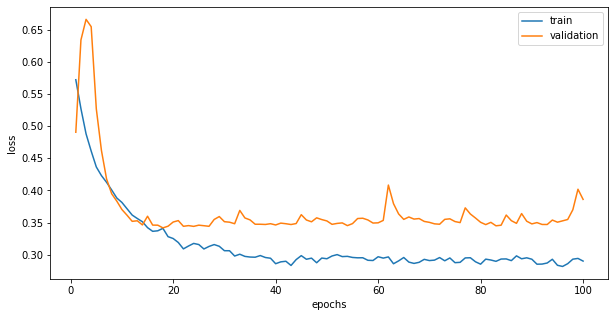

16


In [15]:
epochs_to_show = 100
smoothing = 0.5
plt.figure(figsize=(10,5))
plt.plot(range(1,epochs_to_show+1), smooth(mean_losses_train[0:epochs_to_show],smoothing), label = 'train')
plt.plot(range(1,epochs_to_show+1), smooth(mean_losses_valid[0:epochs_to_show],smoothing), label = 'validation')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend(loc='upper right')
# plt.ylim((0.0, 0.9))
# plt.title('loss graph')
plt.show()
print(best_epoch)